## Import modules

In [1]:
import os
import pandas as pd
import numpy as np

import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import statsmodels.api as sm  

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

os.chdir('/Users/Evan/DataScience/TB_Nation/Datasets//')
files = os.listdir()

## Getting and cleaning data

In [2]:
datasets = pd.DataFrame()
for i in range(1,len(files)):
    for j in os.listdir(files[i]):
        data = pd.read_excel(files[i]+'/'+ j ,skiprows=1).iloc[:1,0:5]
        data = data.rename(columns={'Unnamed: 0':'Area','发病数':'Incidence','死亡数':'Death','发病率':'Incidence_rate','死亡率':'Death_rate'})
        data['Year'],data['Month'],data['Day'] = files[i],j[4:6],'01'
        datasets = pd.concat([datasets,data])
# datasets.index=range(0,len(datasets))
datasets['Date'] = datasets['Year'] + datasets['Month'] + datasets['Day']
datasets.index = pd.to_datetime(datasets['Date'])
datasets = datasets.drop(['Day','Date'],axis=1)
datasets.shape

(120, 7)

In [3]:
datasets.to_excel('/Users/Evan/Desktop/TB_nation.xlsx')

## Exploratory Data analysis

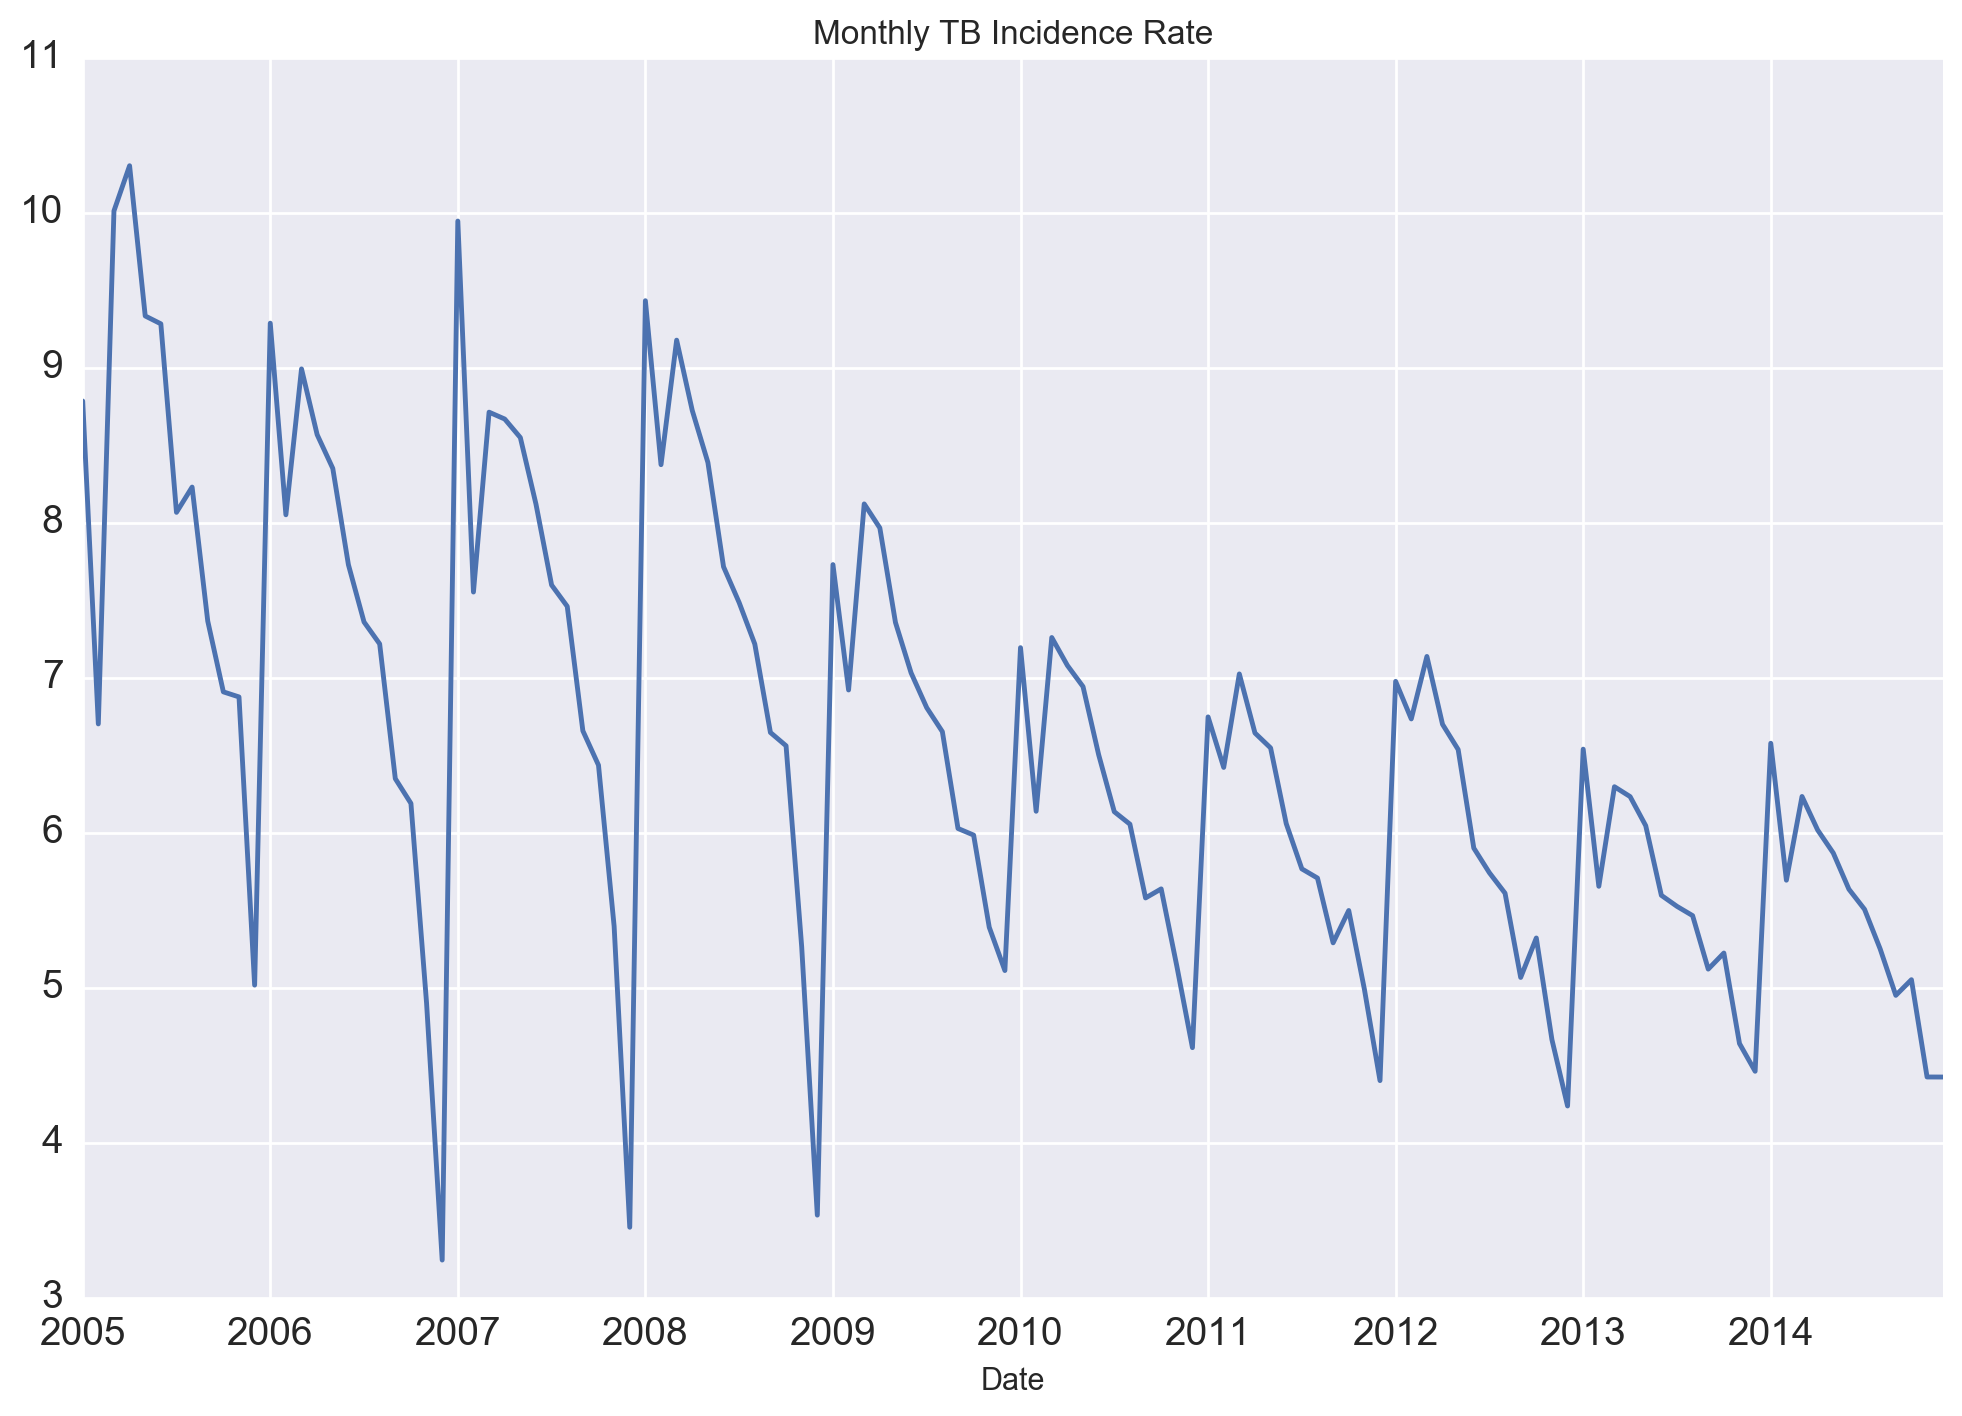

In [4]:
datasets.Incidence_rate.plot(figsize=(12,8), title= 'Monthly TB Incidence Rate', fontsize=14)
# plt.savefig('month_TB.png', bbox_inches='tight')

In [5]:
datasets_pred = datasets[datasets.index>='2013-01-1']
datasets = datasets[datasets.index<'2013-01-01']
datasets.shape
datasets_pred

,Area,Incidence,Death,Incidence_rate,Death_rate,Year,Month
Date,,,,,,,
2013-01-01,全 国,88539,233,6.538876,0.017208,2013,01
2013-02-01,全 国,76557,216,5.653969,0.015952,2013,02
2013-03-01,全 国,85255,238,6.296343,0.017577,2013,03
2013-04-01,全 国,84395,211,6.232829,0.015583,2013,04
2013-05-01,全 国,81852,237,6.045021,0.017503,2013,05
2013-06-01,全 国,75769,205,5.595773,0.015140,2013,06
2013-07-01,全 国,74805,247,5.524578,0.018242,2013,07
2013-08-01,全 国,73995,203,5.464757,0.014992,2013,08
2013-09-01,全 国,69323,206,5.119716,0.015214,2013,09


In [6]:
decomposition = seasonal_decompose(datasets.Incidence_rate,freq=12)

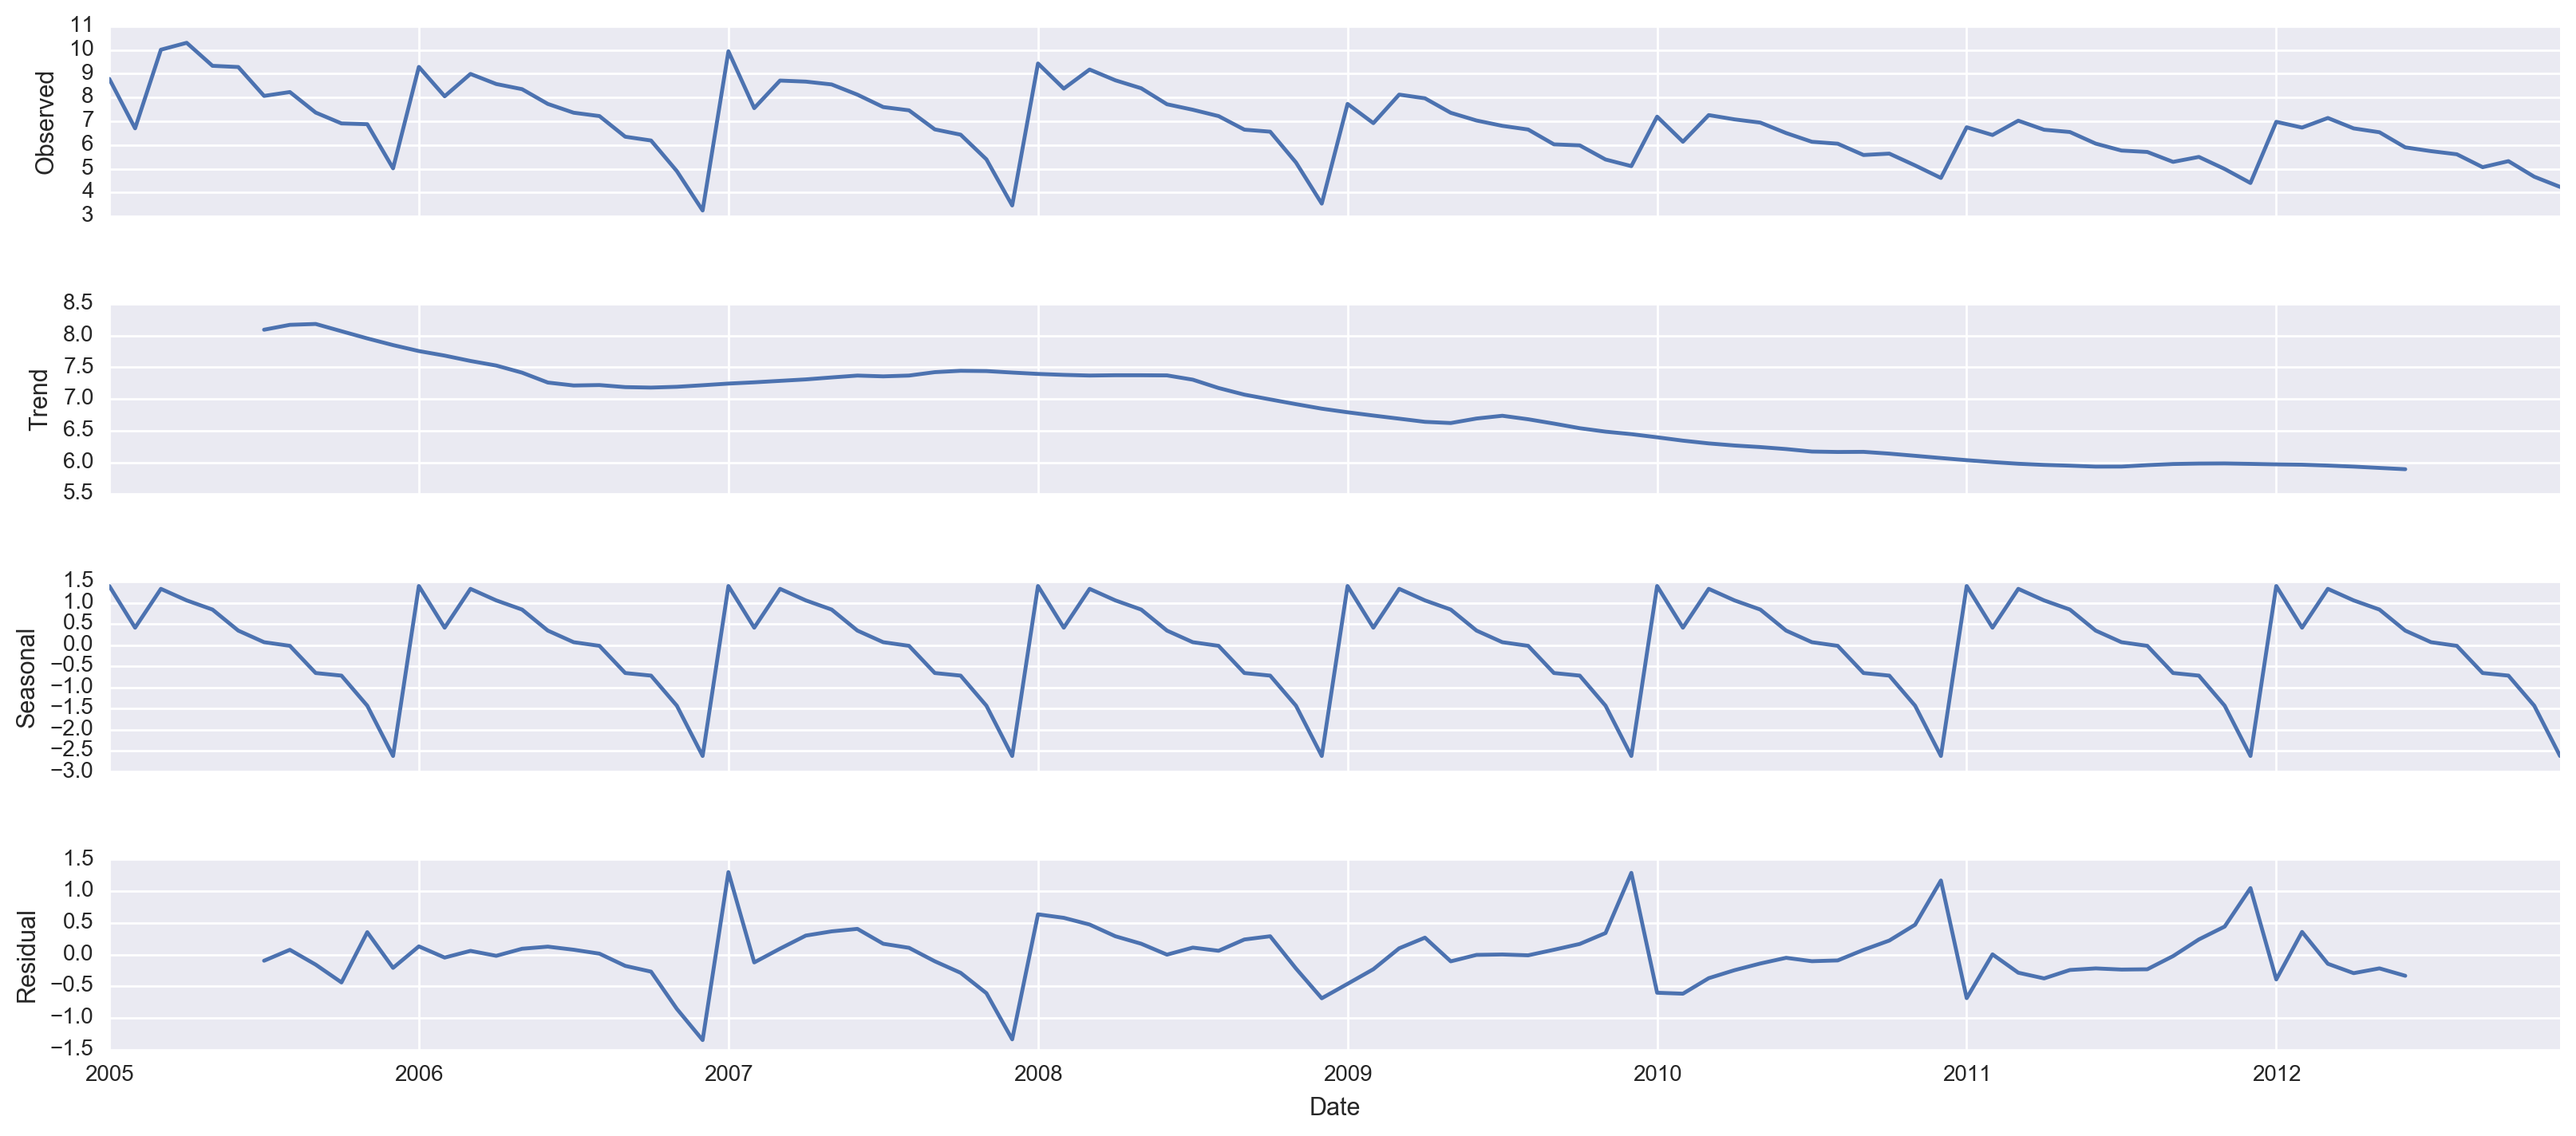

In [7]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(18,8)

## SARIMA

### Test of stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

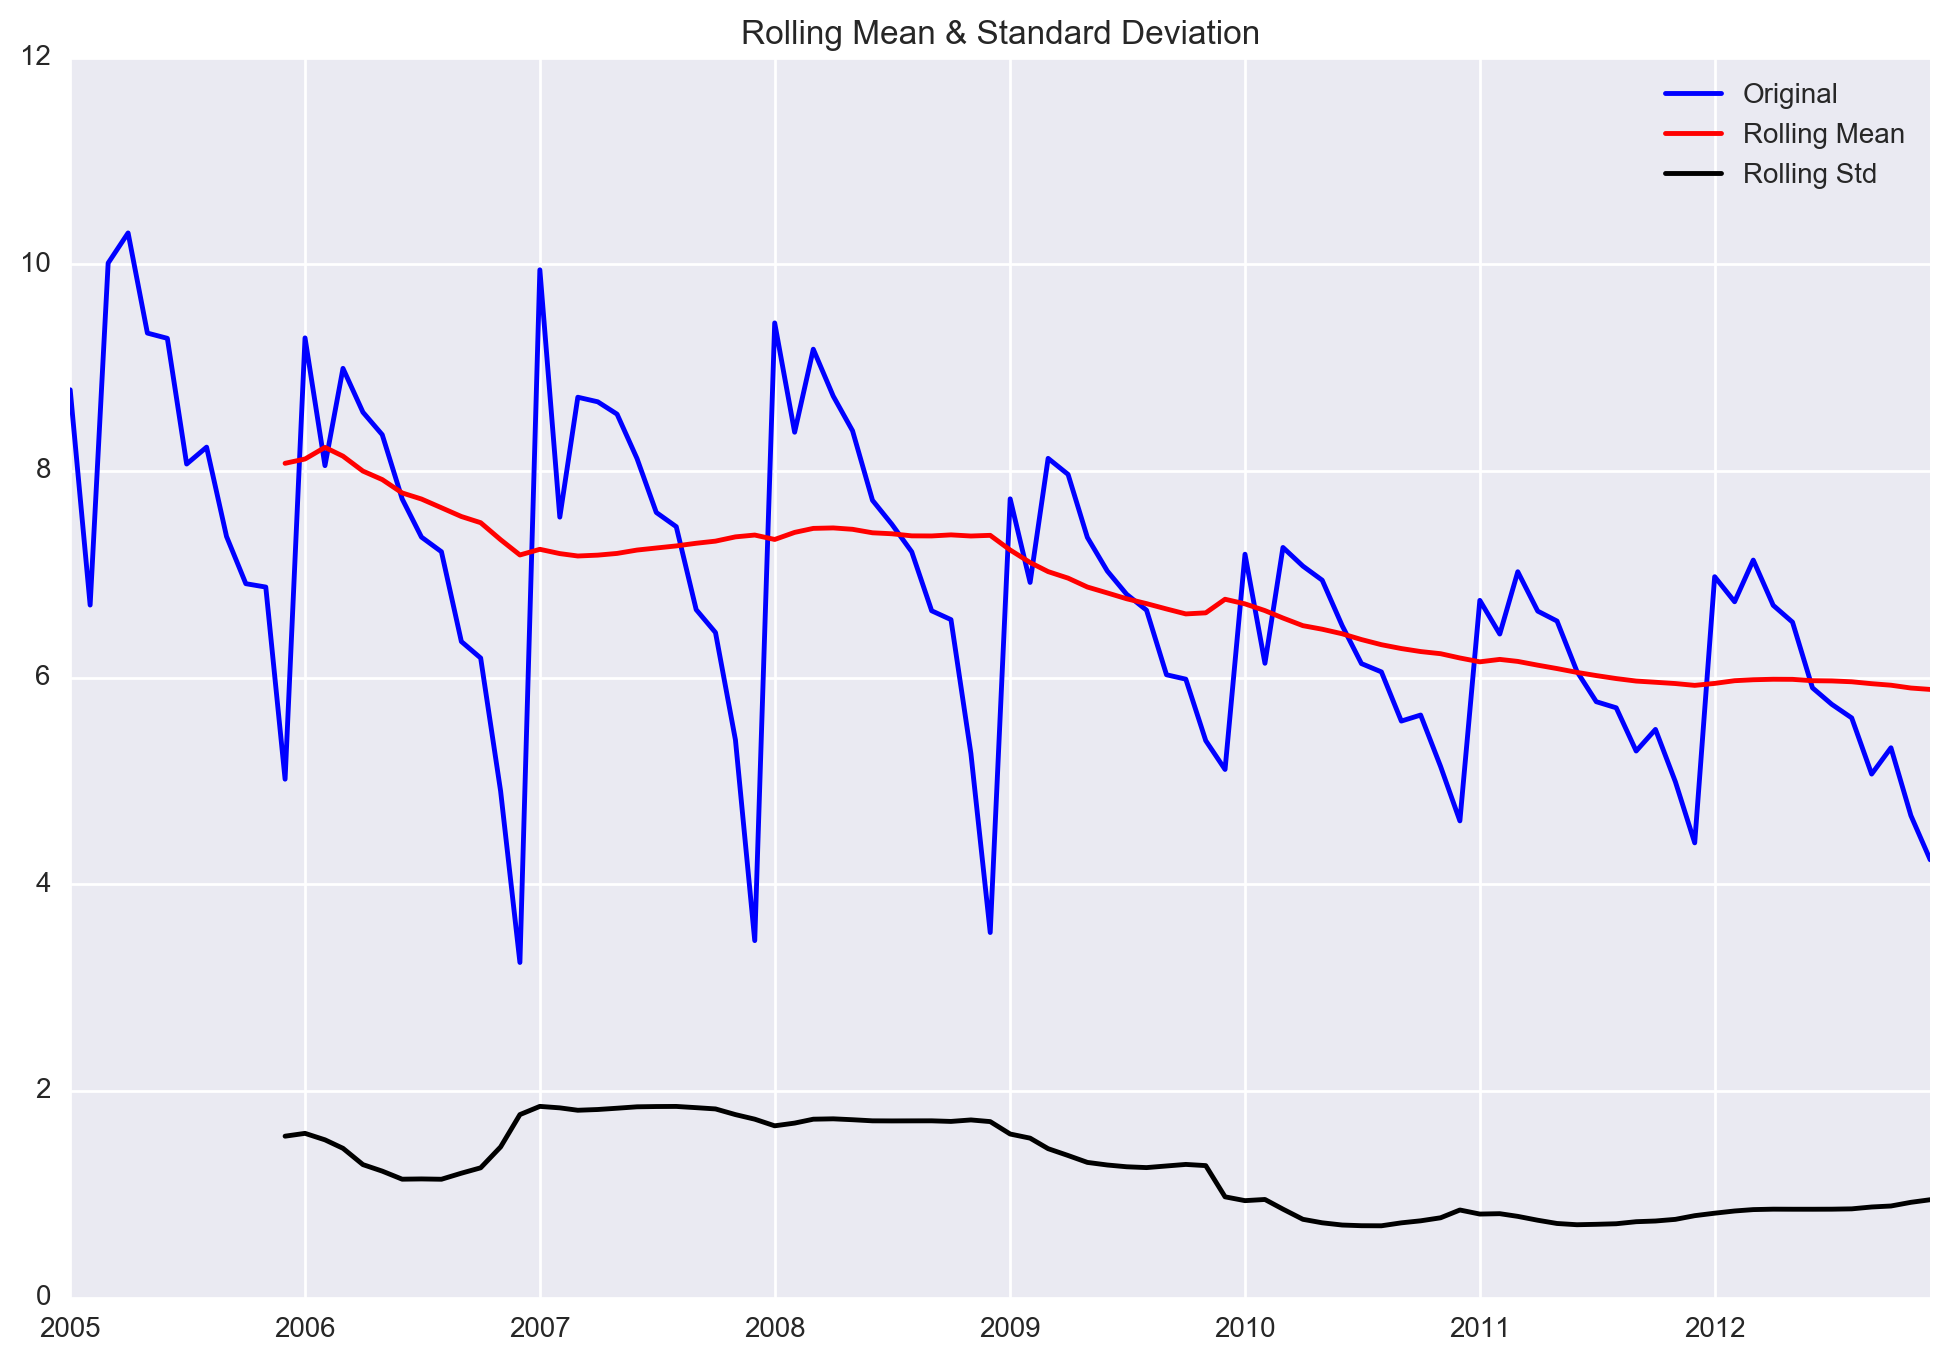

Results of Dickey-Fuller Test:
Test Statistic                 -1.388933
p-value                         0.587570
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (10%)           -2.585713
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
dtype: float64


In [9]:
test_stationarity(datasets.Incidence_rate)

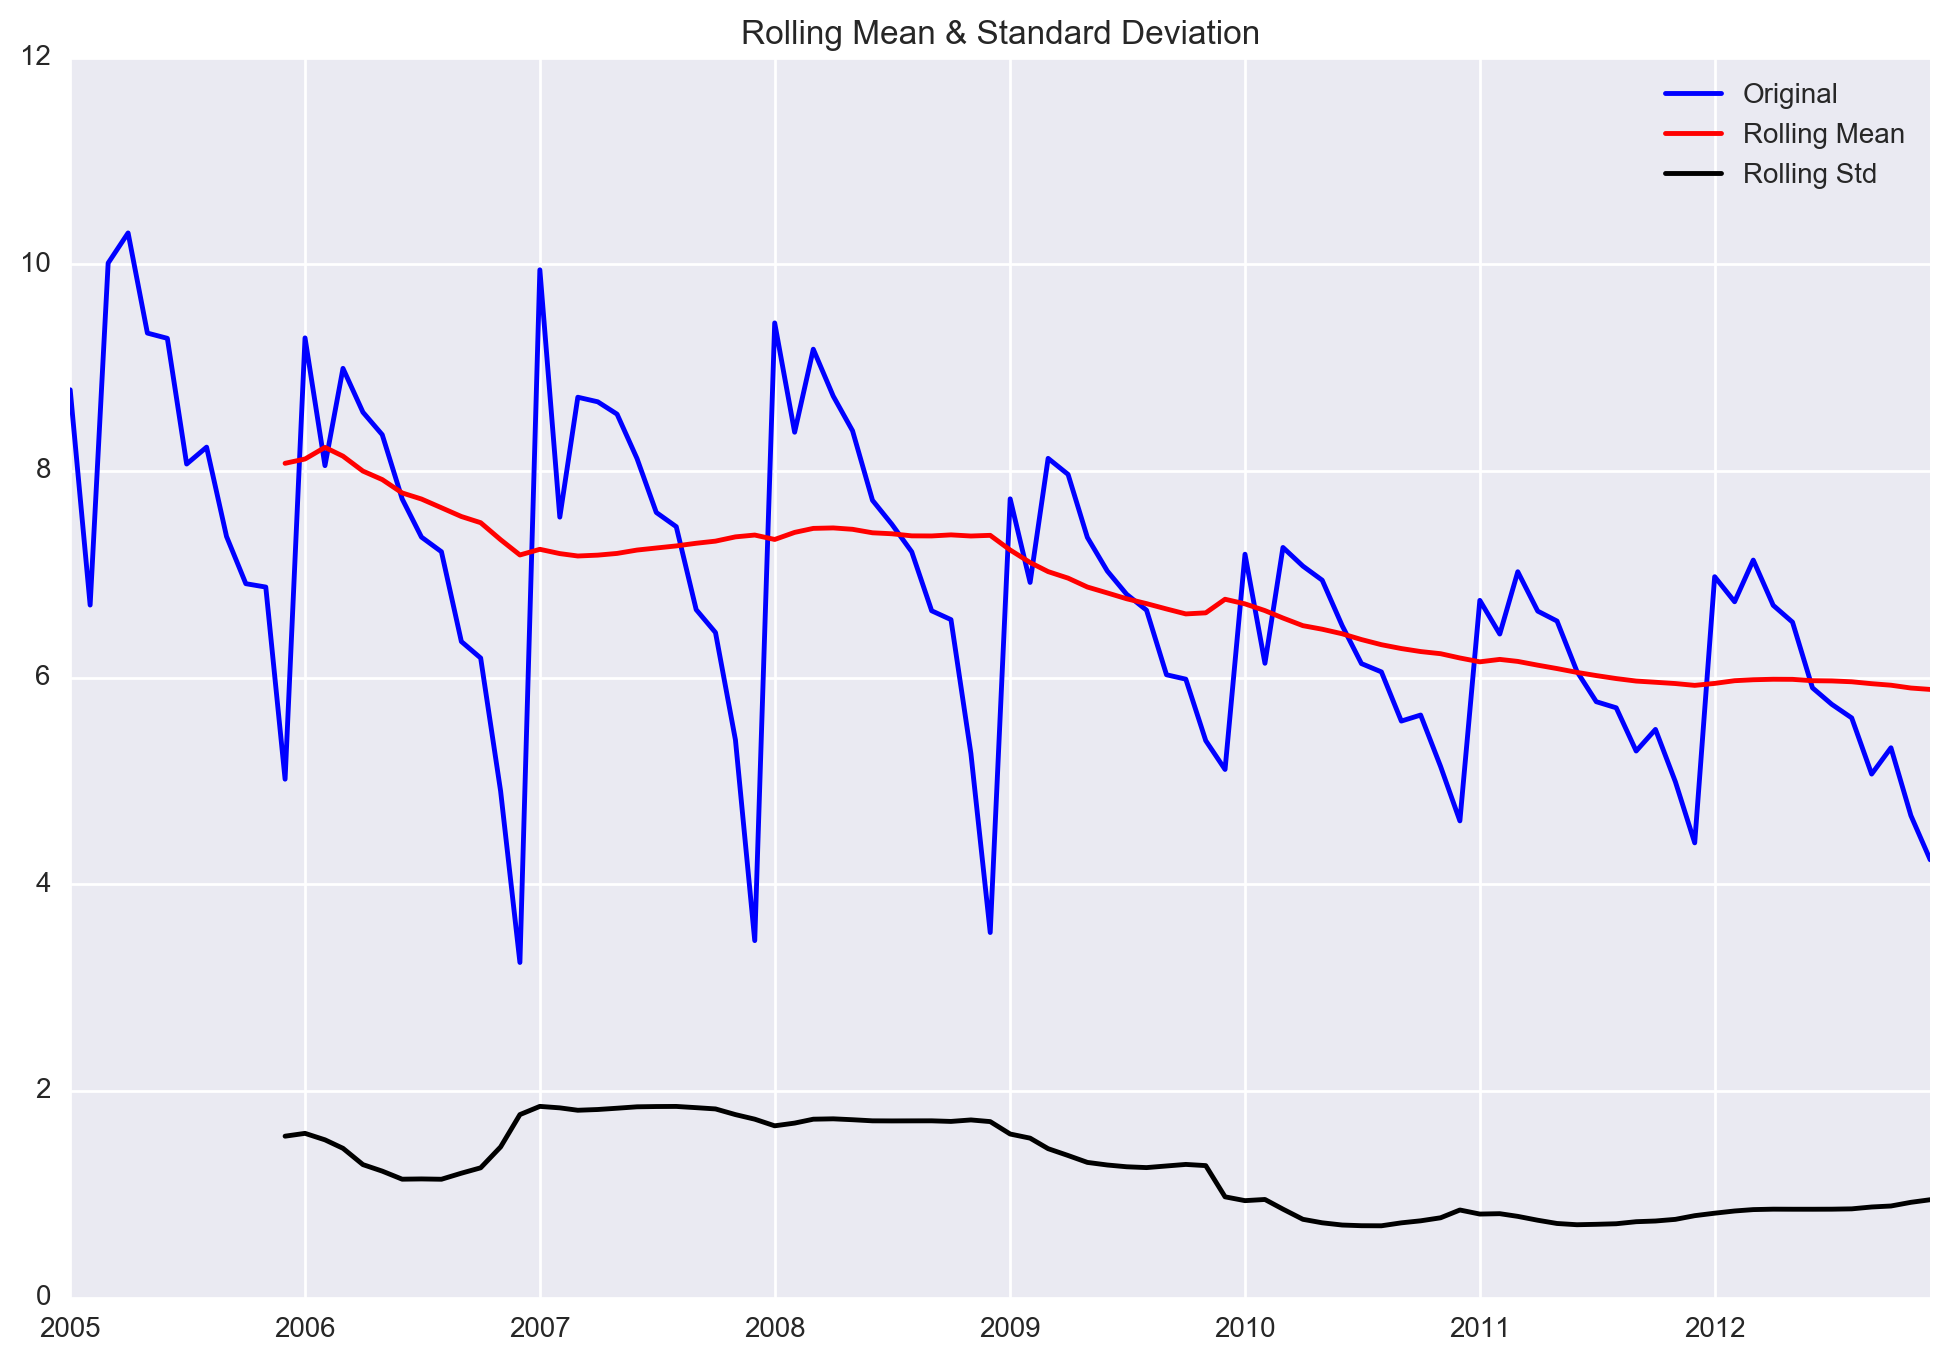

Results of Dickey-Fuller Test:
Test Statistic                 -1.388933
p-value                         0.587570
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (10%)           -2.585713
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
dtype: float64


In [10]:
test_stationarity(datasets['Incidence_rate'])

### First difference

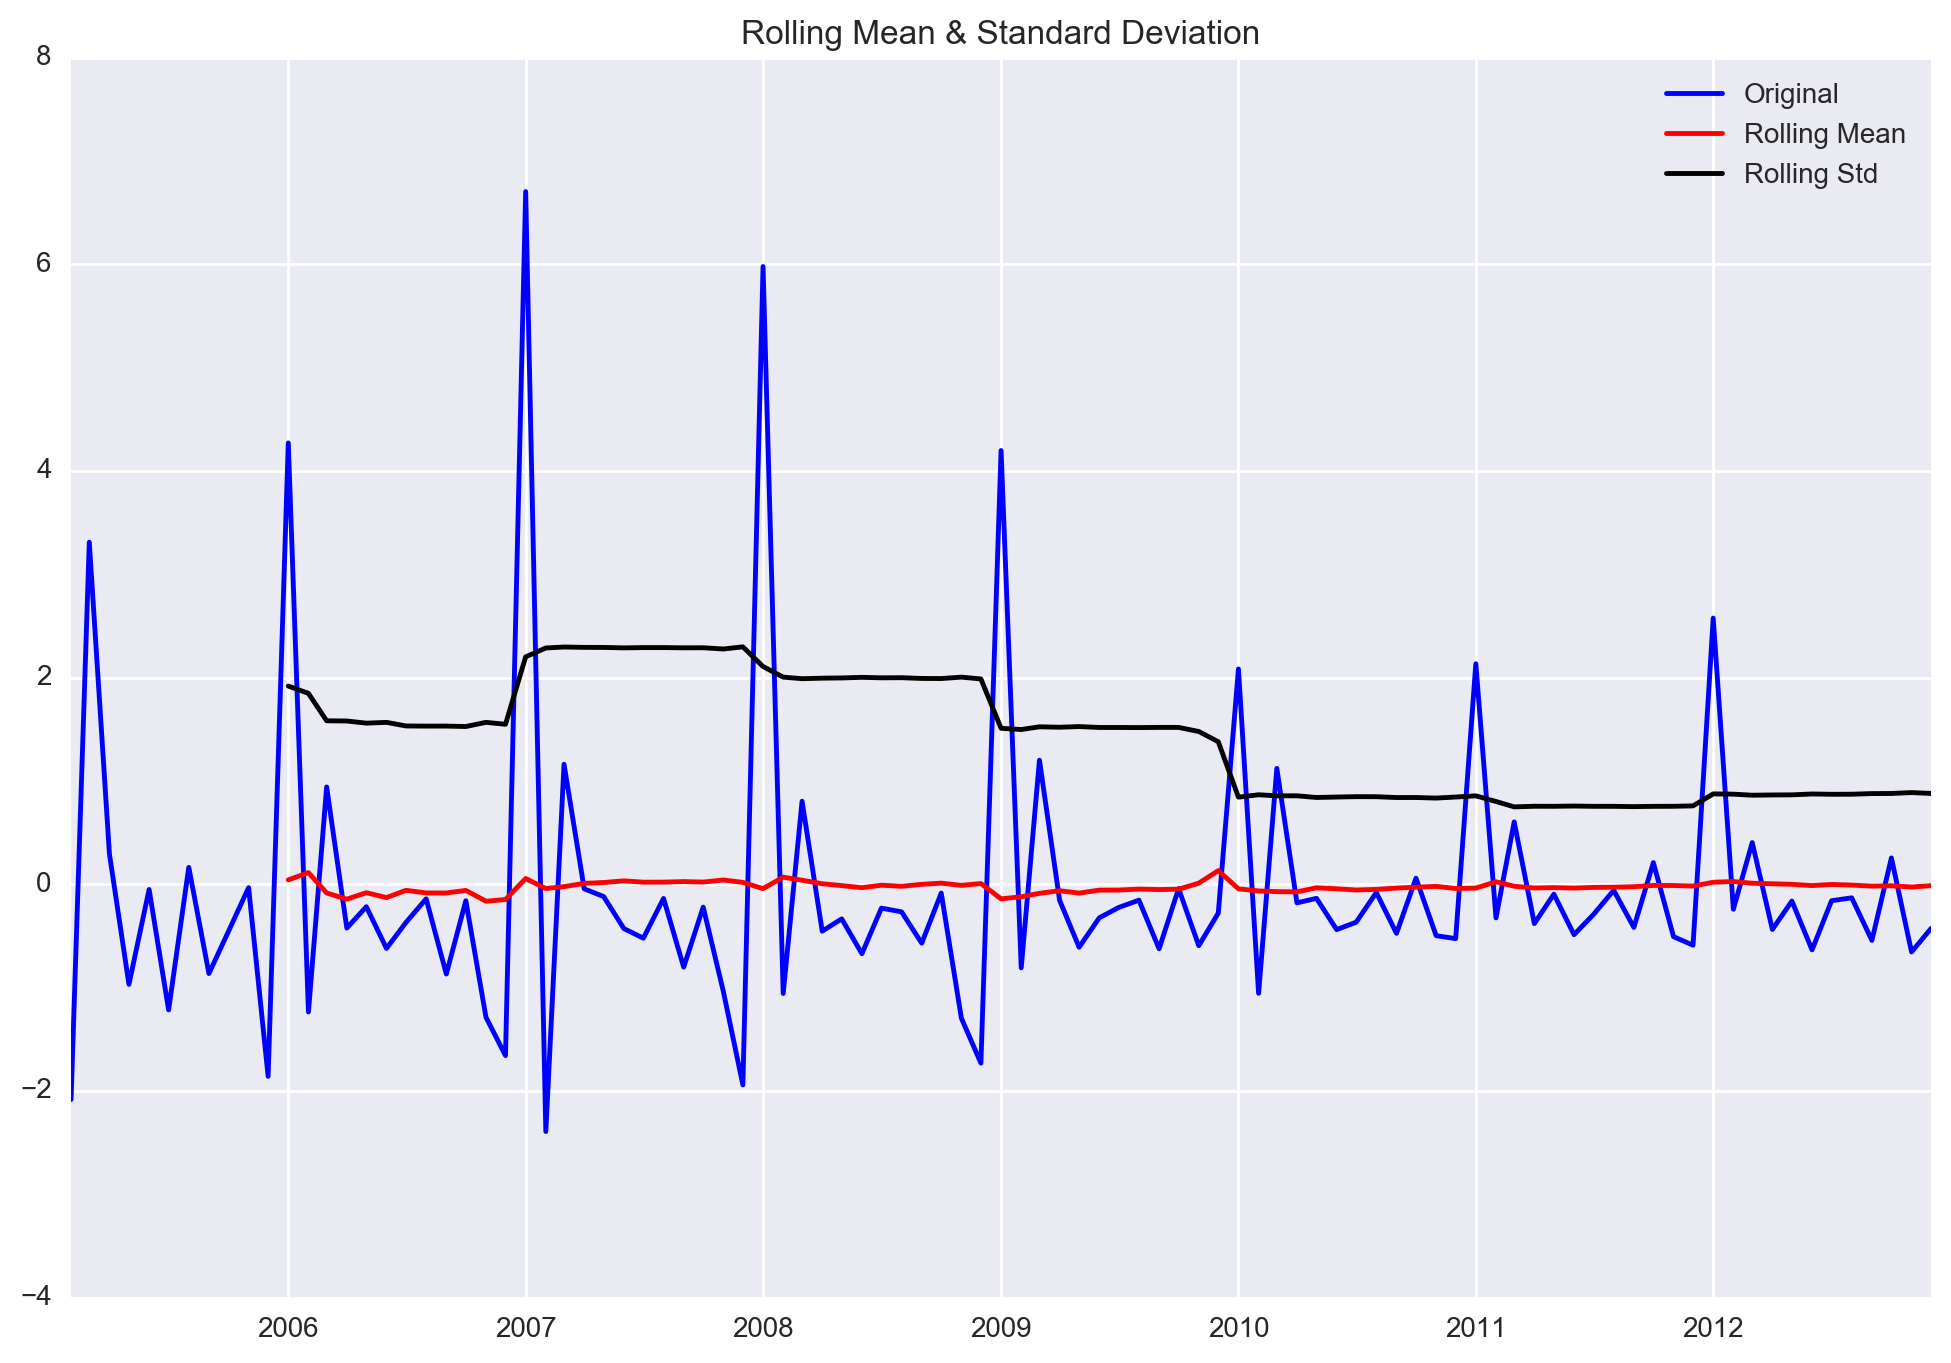

Results of Dickey-Fuller Test:
Test Statistic                 -4.786312
p-value                         0.000058
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (10%)           -2.585713
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
dtype: float64


In [11]:
datasets['first_diff'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(1)
test_stationarity(datasets.first_diff.dropna(inplace=False))

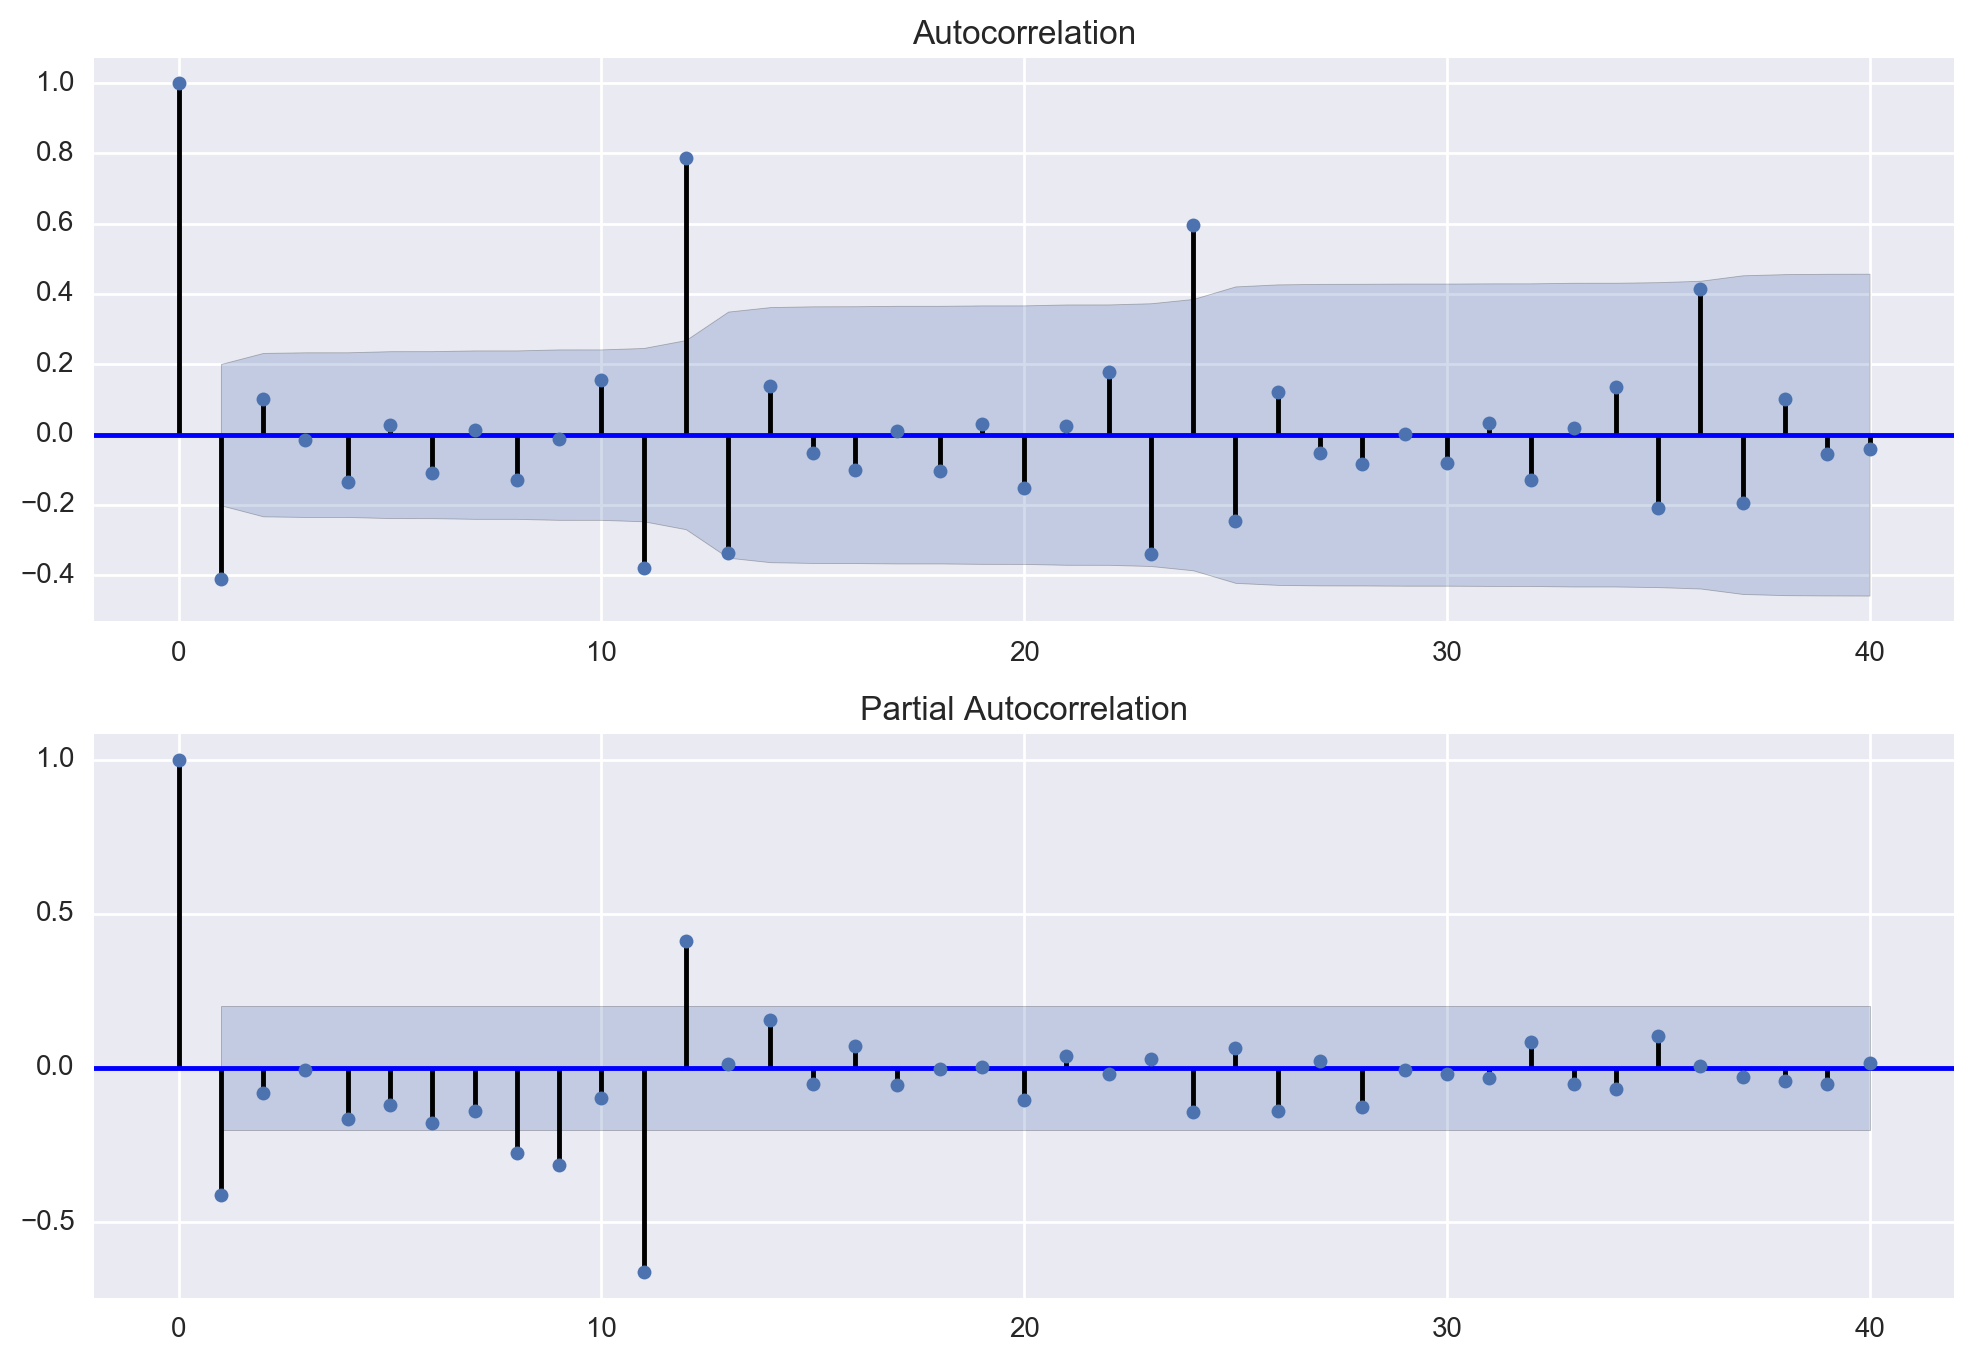

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.first_diff.iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.first_diff.iloc[1:], lags=40, ax=ax2)

### Seasonal difference

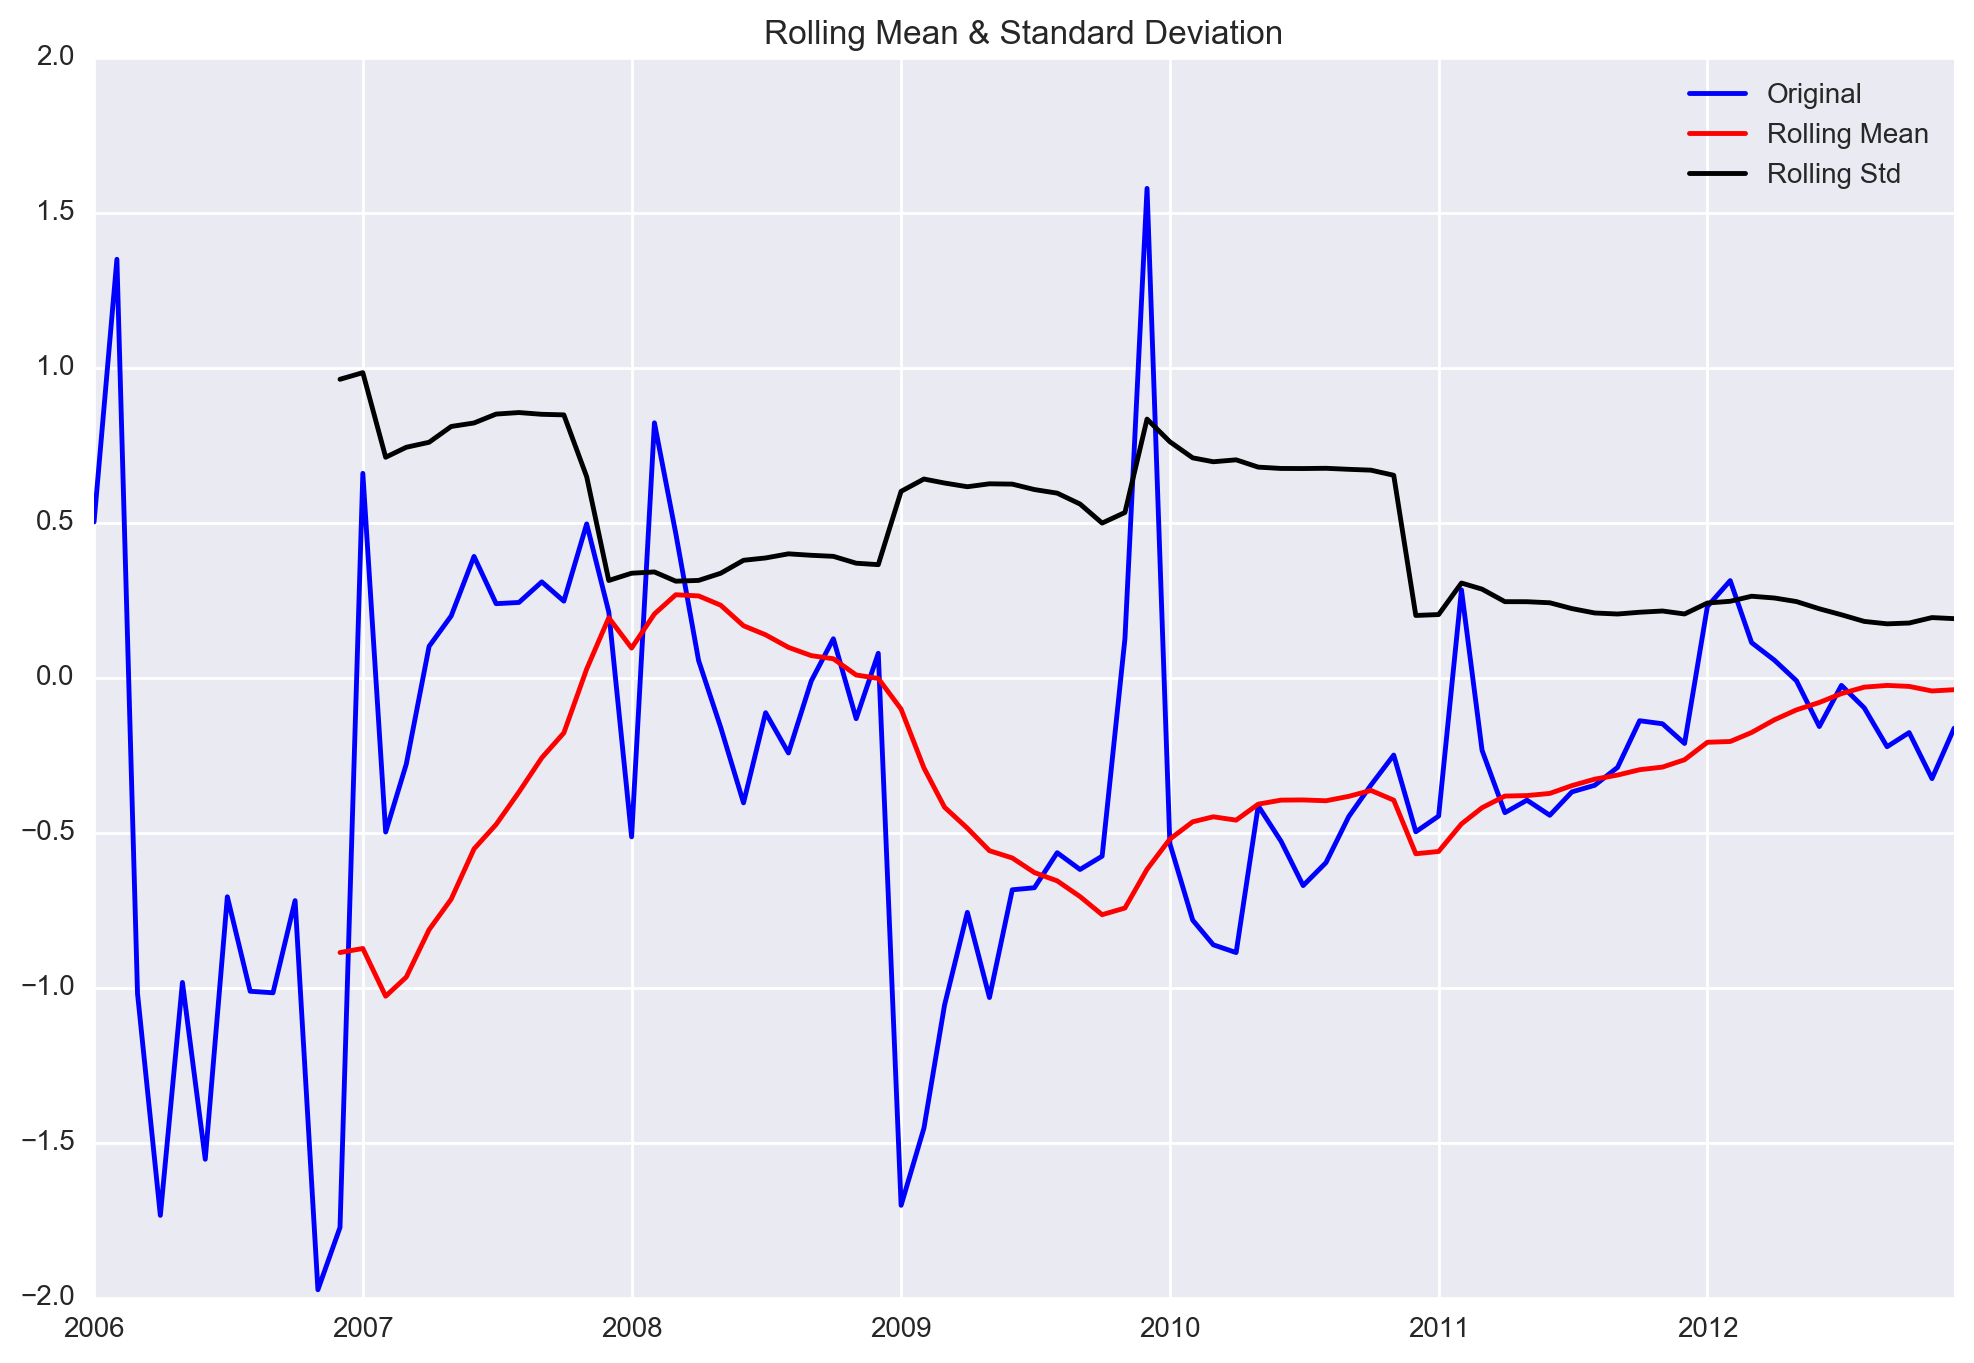

Results of Dickey-Fuller Test:
Test Statistic                 -5.408815
p-value                         0.000003
#Lags Used                      0.000000
Number of Observations Used    83.000000
Critical Value (10%)           -2.585713
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
dtype: float64


In [13]:
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)  
test_stationarity(datasets.seasonal_difference.dropna(inplace=False))

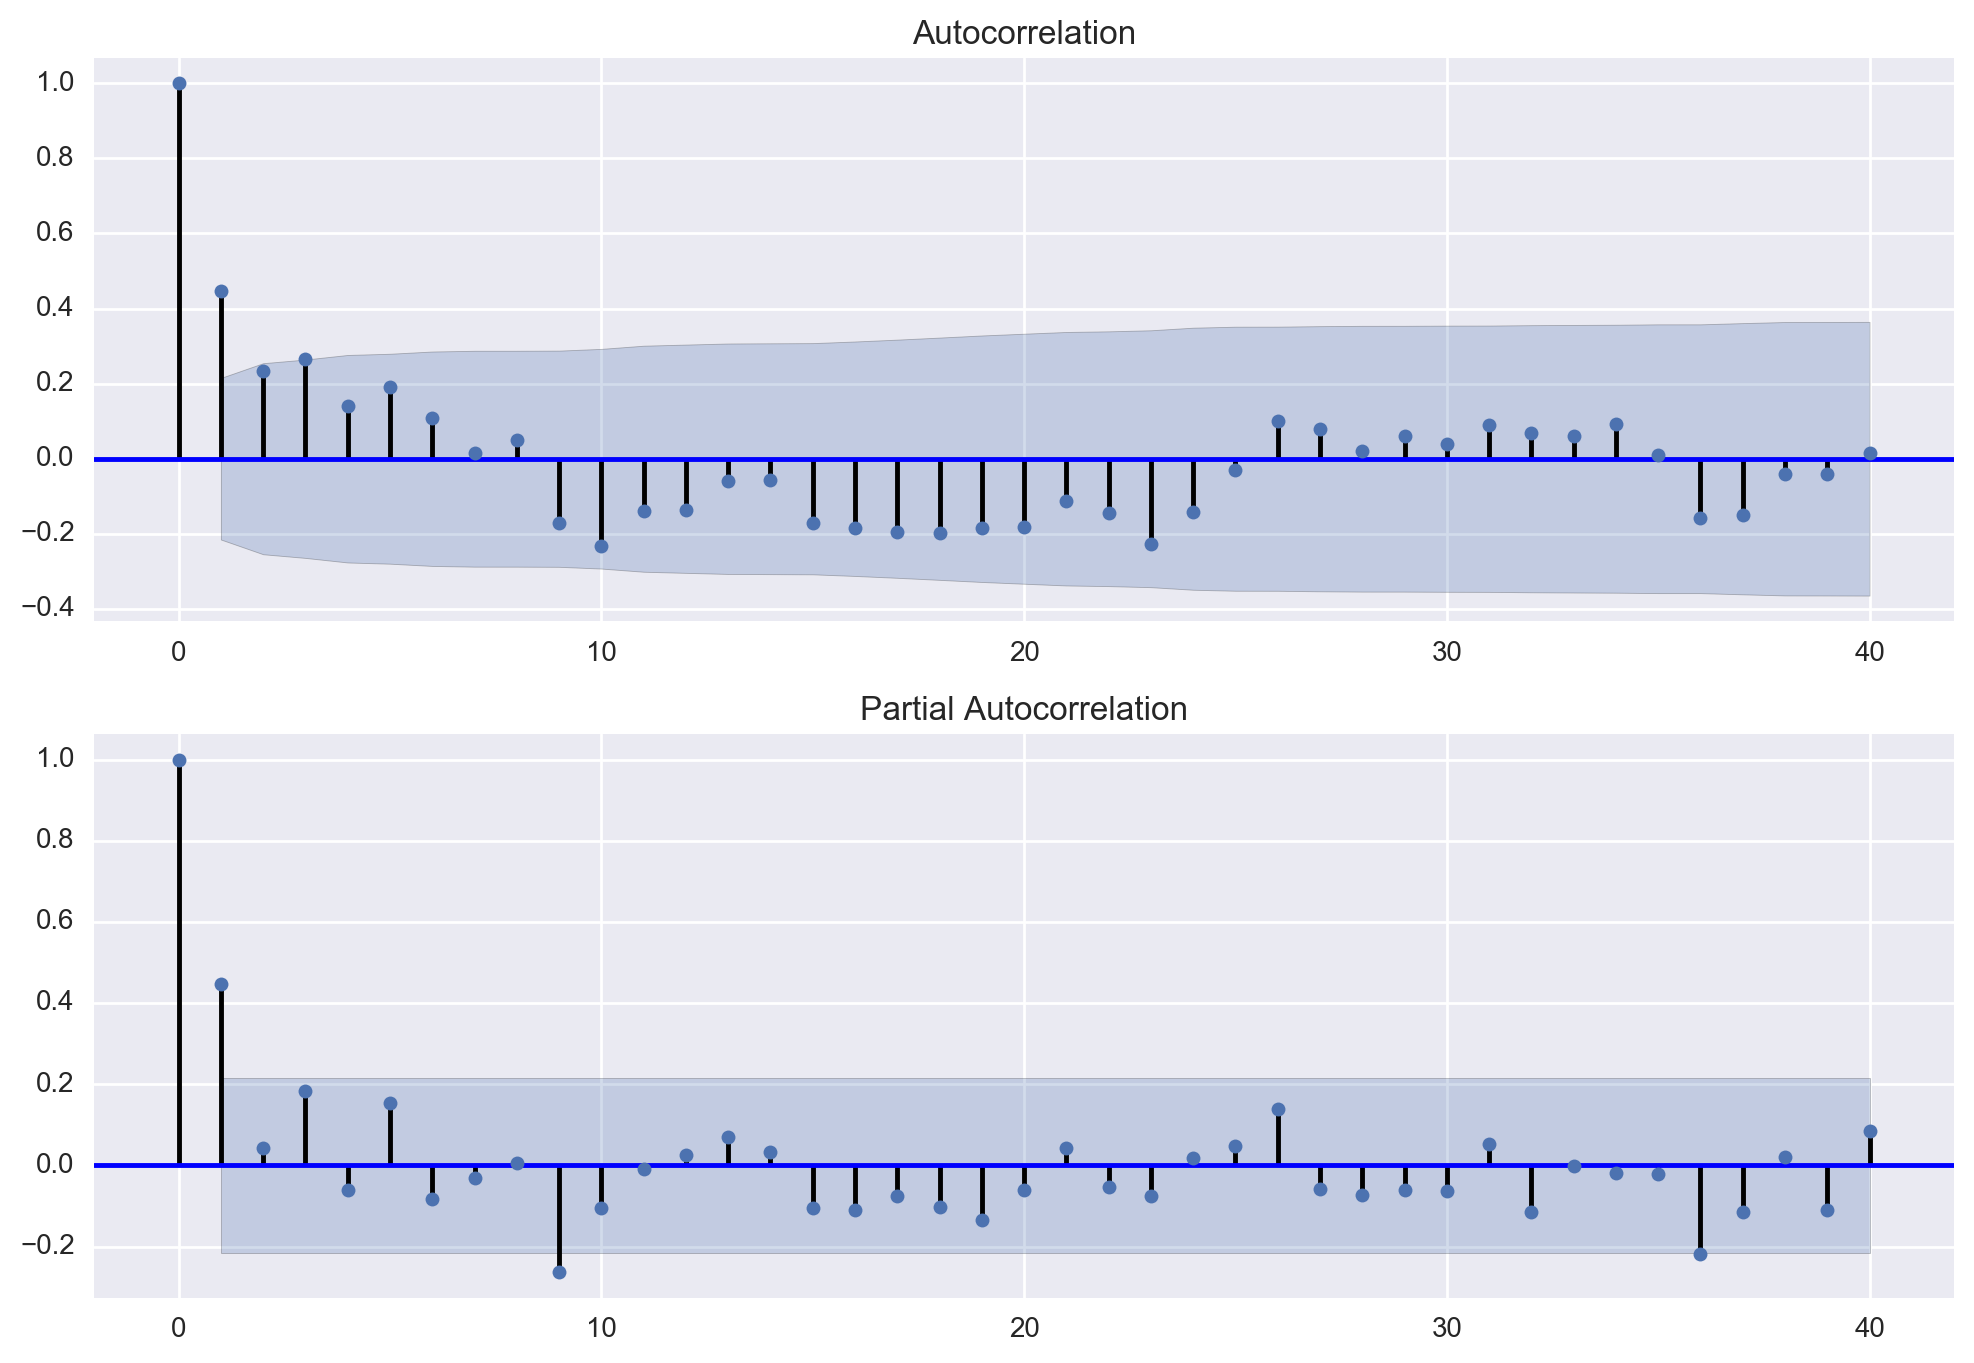

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_difference.iloc[13:], lags=40, ax=ax2)

In [15]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(4,1,0), seasonal_order=(4,1,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                   96
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 12)   Log Likelihood                 -65.097
Date:                            Thu, 12 Jan 2017   AIC                            148.193
Time:                                    21:31:50   BIC                            171.273
Sample:                                01-01-2005   HQIC                           157.522
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3937      0.115     -3.418      0.001      -0.619      -0.168
ar.L2         -0.4992      0.130   

### Seasonal first difference 

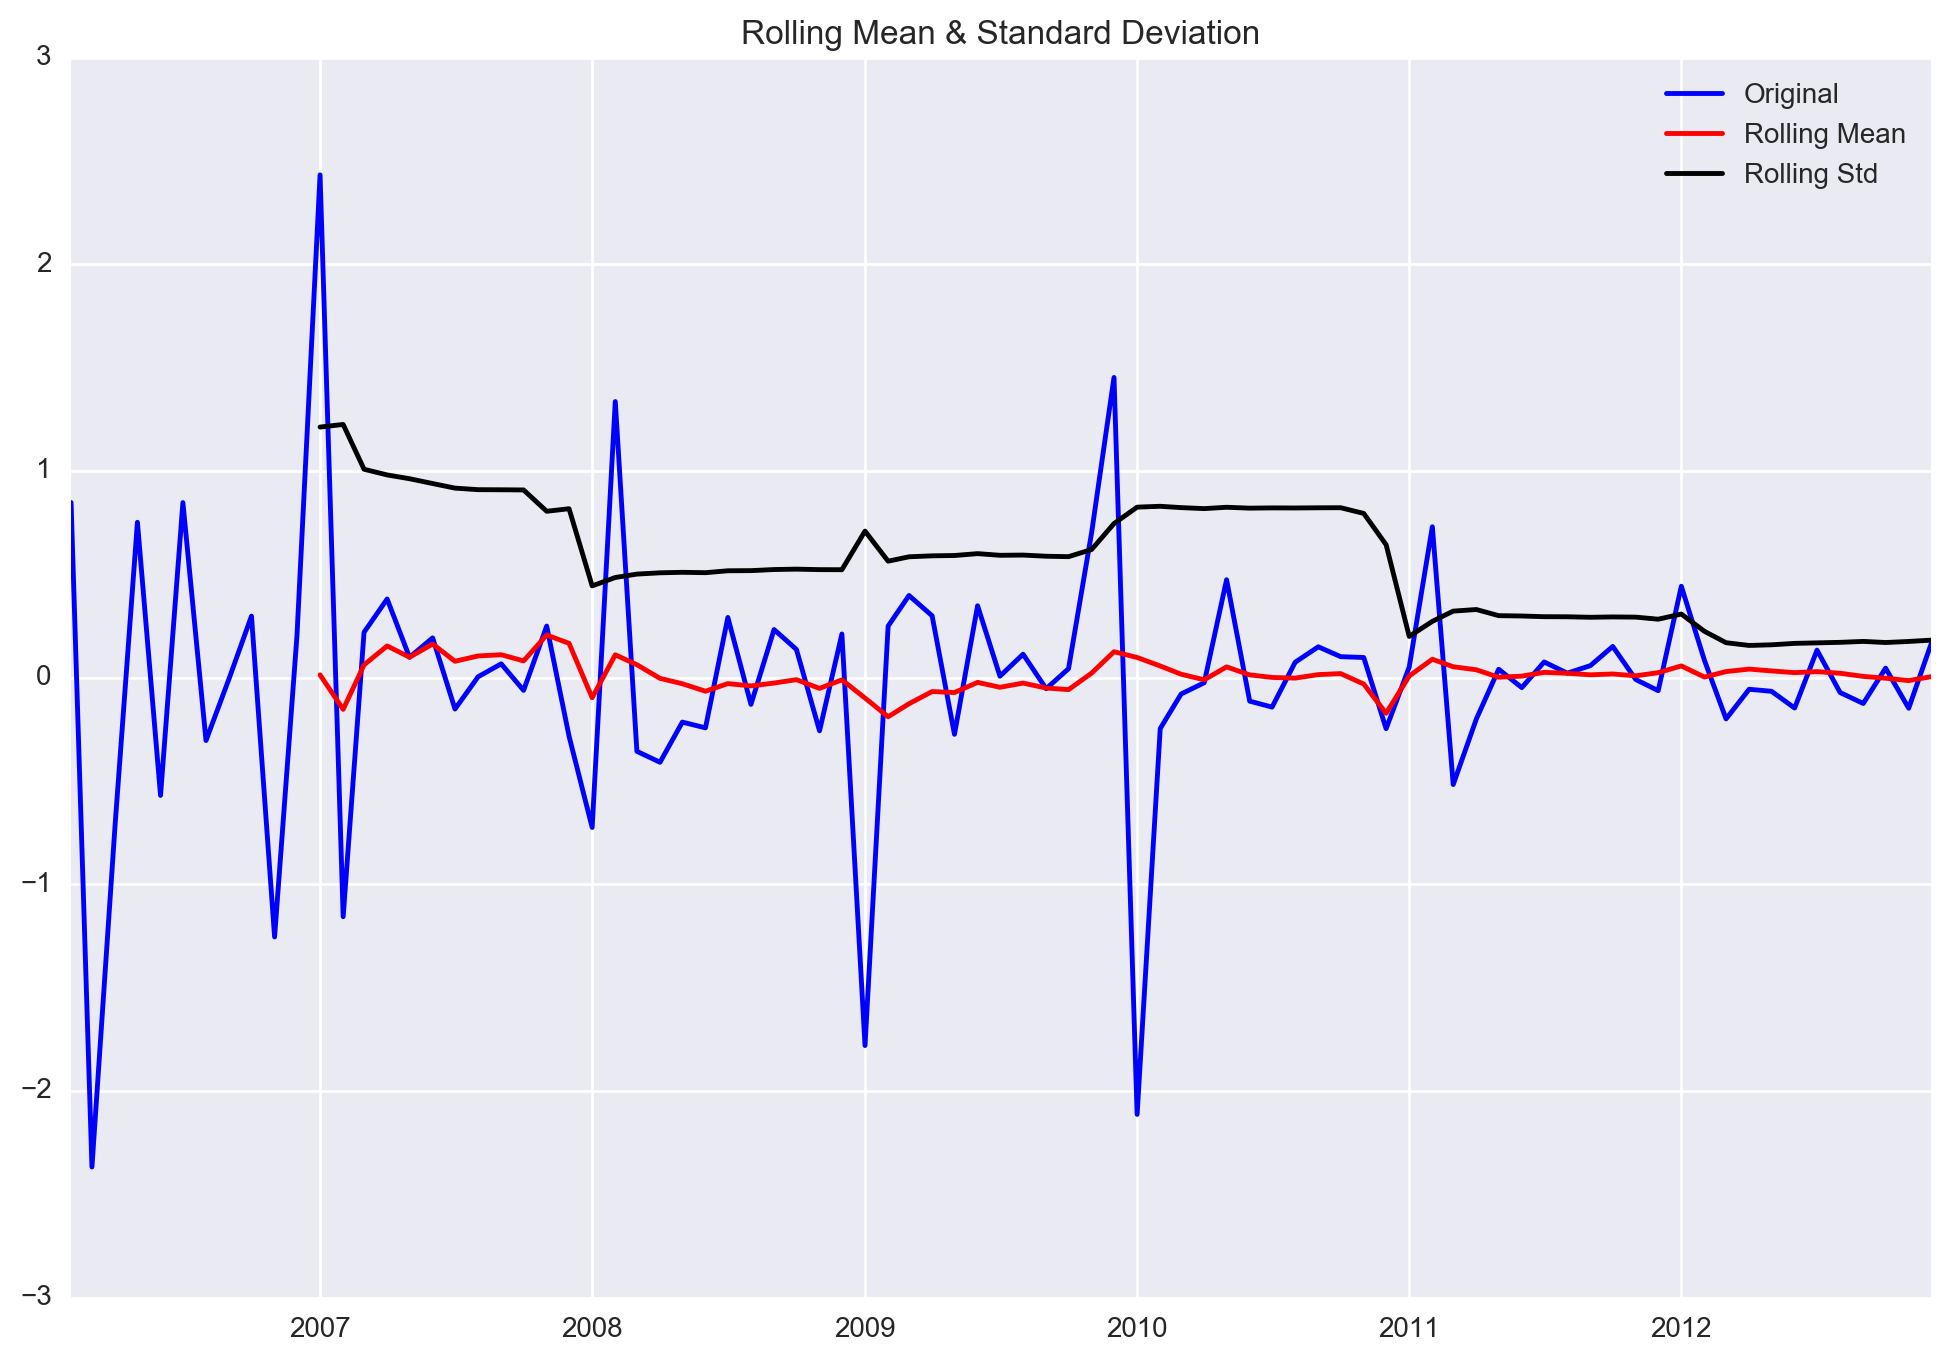

Results of Dickey-Fuller Test:
Test Statistic                -1.018956e+01
p-value                        6.375189e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (10%)          -2.586191e+00
Critical Value (5%)           -2.897943e+00
Critical Value (1%)           -3.513790e+00
dtype: float64


In [16]:
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

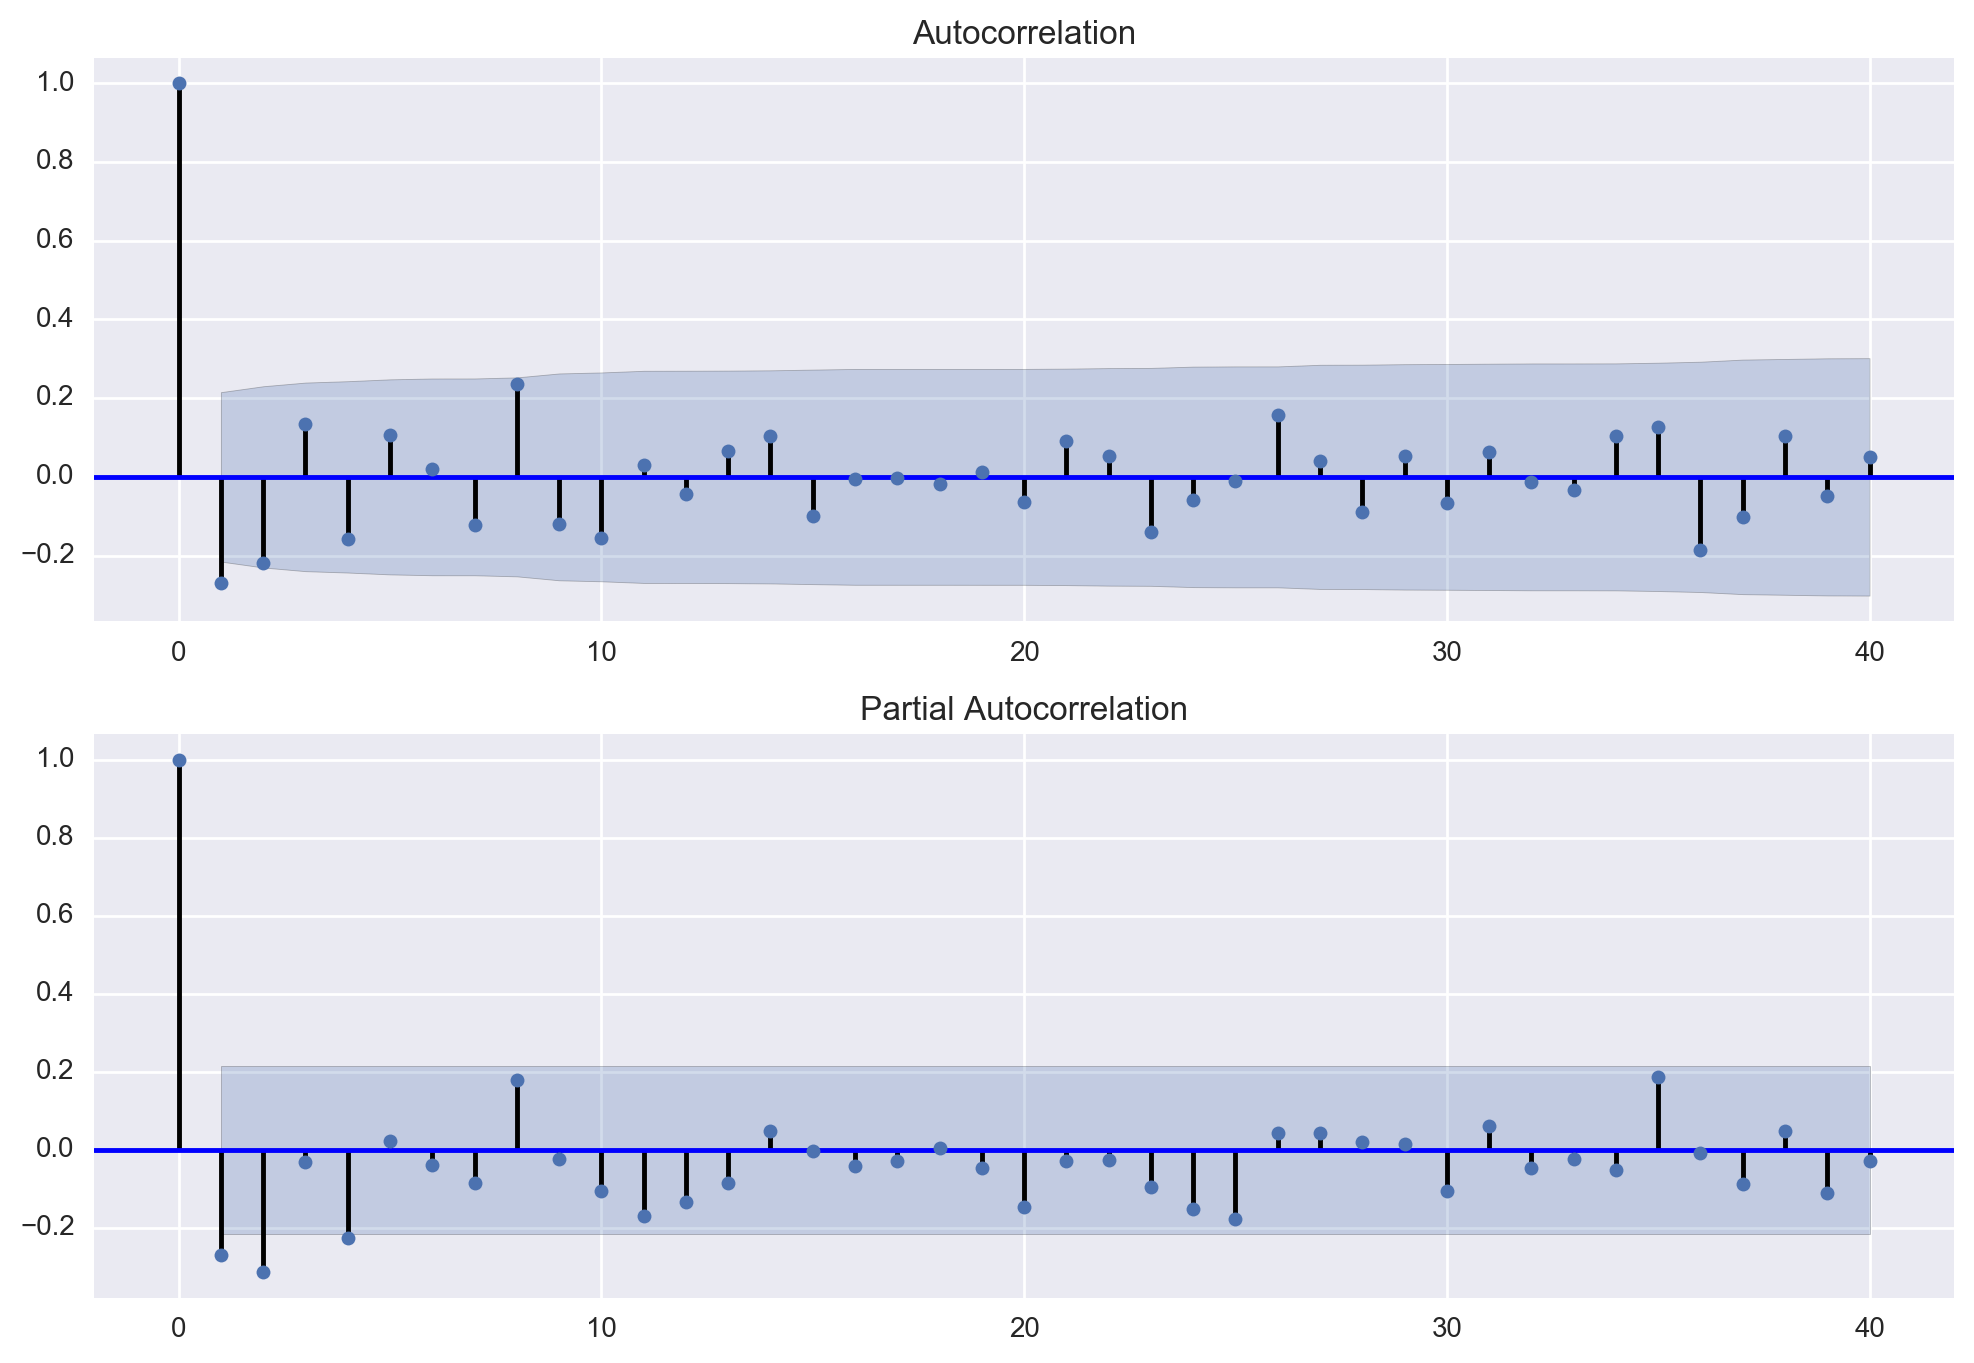

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

## Bulid Model

In [18]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(0,1,2), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                   96
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 -70.245
Date:                            Thu, 12 Jan 2017   AIC                            148.490
Time:                                    21:31:53   BIC                            158.748
Sample:                                01-01-2005   HQIC                           152.636
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4169      0.121     -3.447      0.001      -0.654      -0.180
ma.L2         -0.4211      0.098   

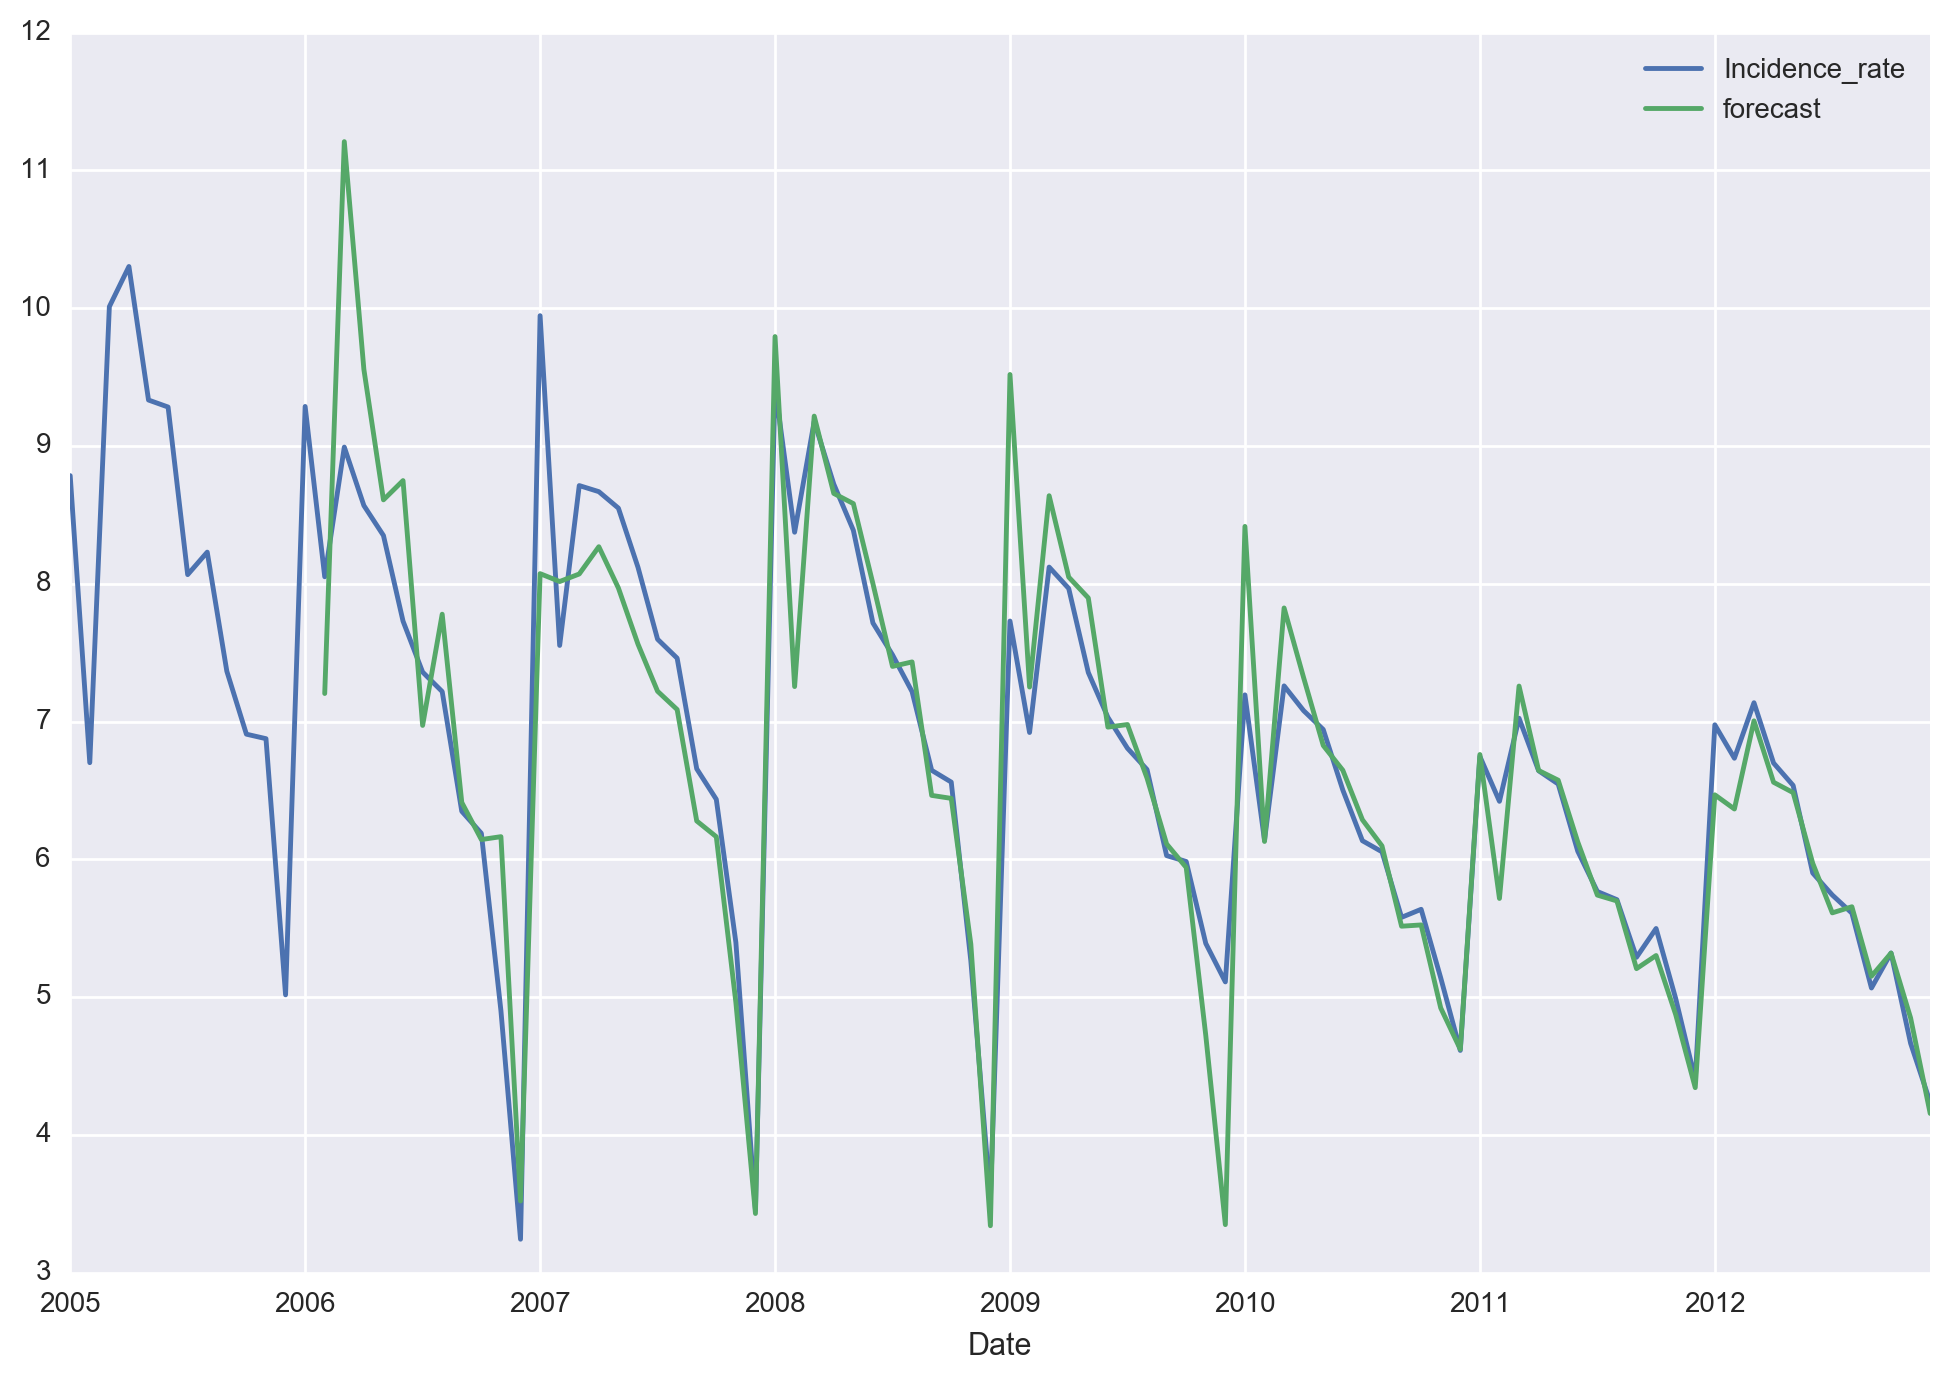

In [19]:
datasets['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
datasets[['Incidence_rate', 'forecast']].plot(figsize=(12, 8))

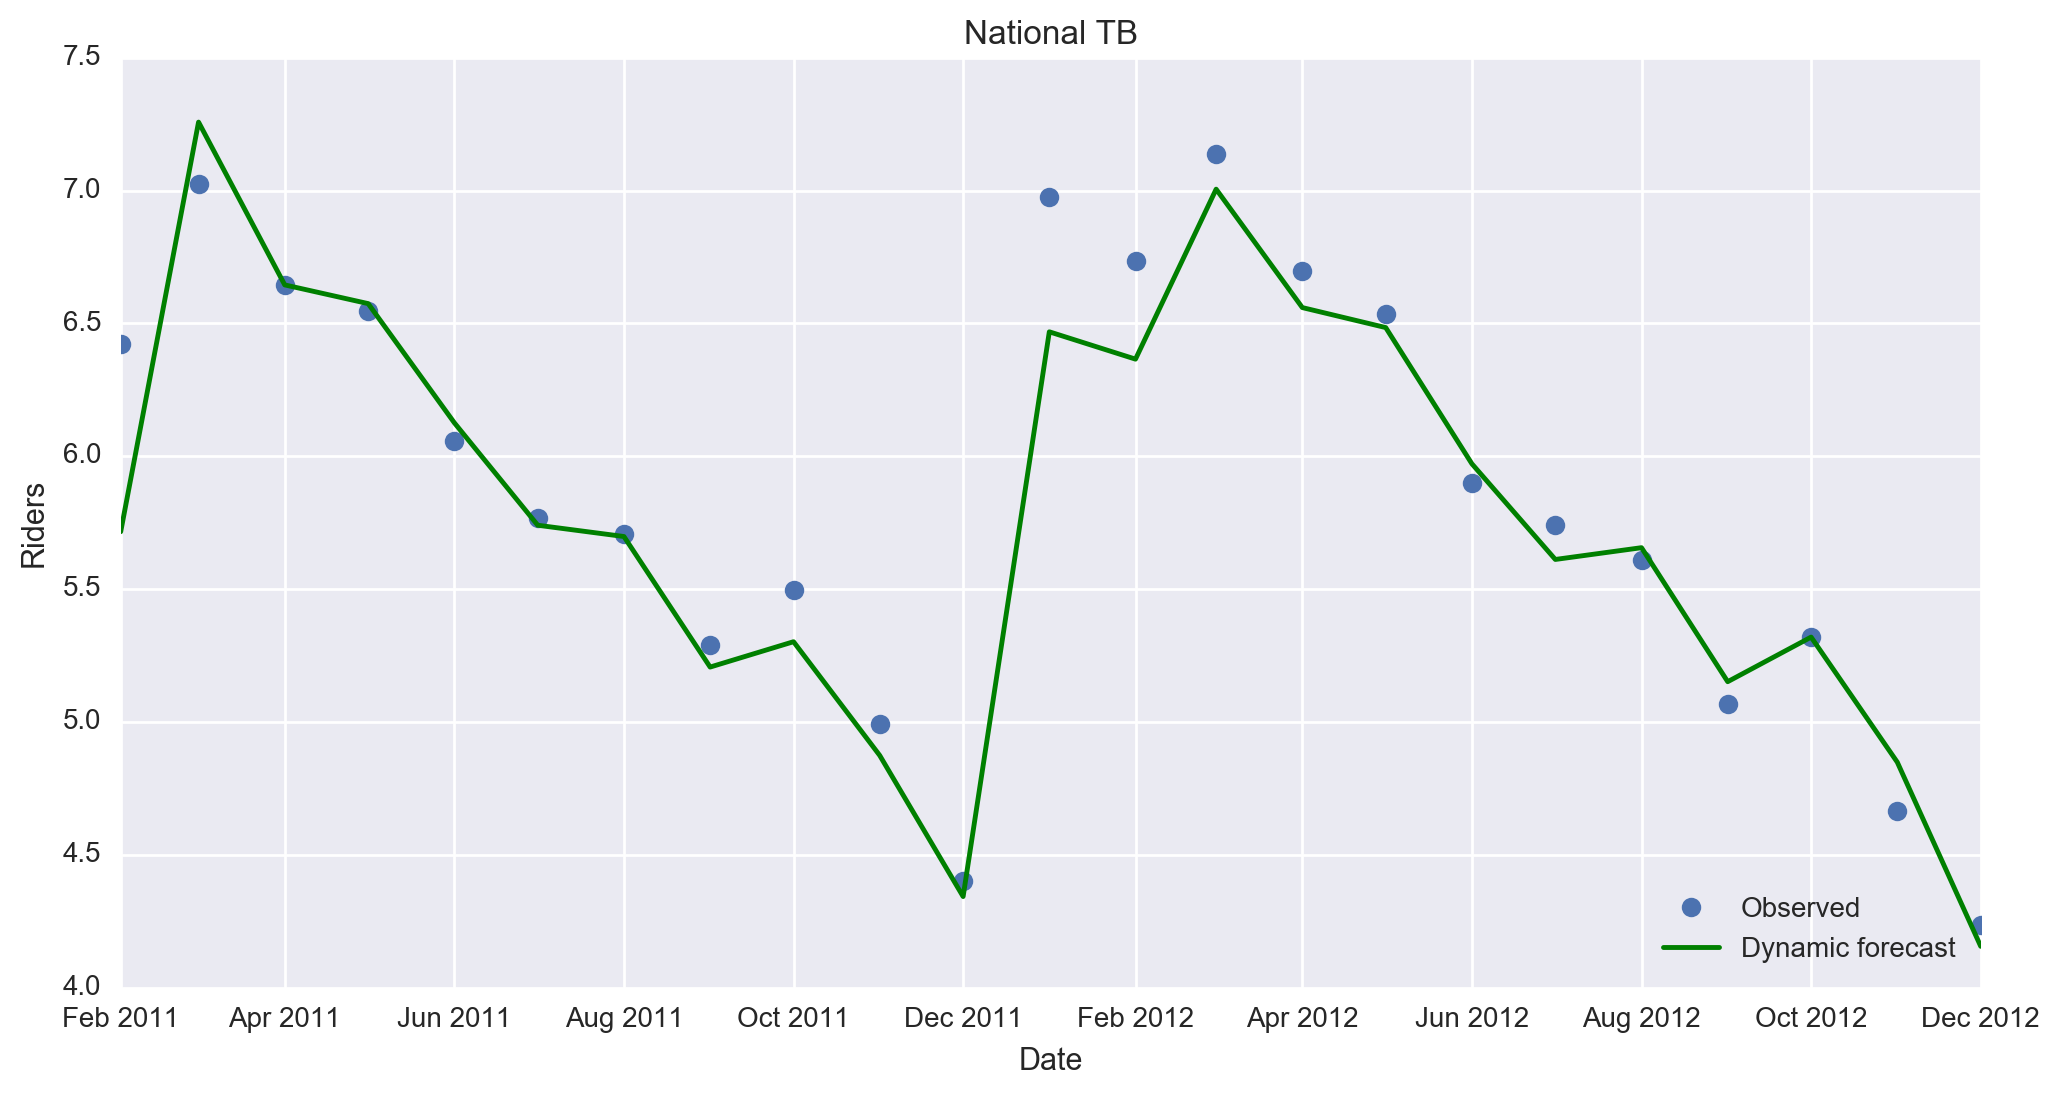

In [20]:
npredict =datasets.Incidence_rate['2005'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='National TB', xlabel='Date', ylabel='Riders')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'Incidence_rate'], 'o', label='Observed')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

In [21]:
datasets_pred

,Area,Incidence,Death,Incidence_rate,Death_rate,Year,Month
Date,,,,,,,
2013-01-01,全 国,88539,233,6.538876,0.017208,2013,01
2013-02-01,全 国,76557,216,5.653969,0.015952,2013,02
2013-03-01,全 国,85255,238,6.296343,0.017577,2013,03
2013-04-01,全 国,84395,211,6.232829,0.015583,2013,04
2013-05-01,全 国,81852,237,6.045021,0.017503,2013,05
2013-06-01,全 国,75769,205,5.595773,0.015140,2013,06
2013-07-01,全 国,74805,247,5.524578,0.018242,2013,07
2013-08-01,全 国,73995,203,5.464757,0.014992,2013,08
2013-09-01,全 国,69323,206,5.119716,0.015214,2013,09


In [22]:
dta = pd.concat([datasets, datasets_pred])
dta.tail(12)

,Area,Death,Death_rate,Incidence,Incidence_rate,Month,Year,first_diff,forecast,seasonal_difference,seasonal_first_difference
Date,,,,,,,,,,,
2014-01-01,全 国,189,0.013947,89128,6.576894,01,2014,NaN,NaN,NaN,NaN
2014-02-01,全 国,178,0.013135,77153,5.693240,02,2014,NaN,NaN,NaN,NaN
2014-03-01,全 国,214,0.015791,84473,6.233394,03,2014,NaN,NaN,NaN,NaN
2014-04-01,全 国,230,0.016972,81543,6.017185,04,2014,NaN,NaN,NaN,NaN
2014-05-01,全 国,212,0.015644,79530,5.868642,05,2014,NaN,NaN,NaN,NaN
2014-06-01,全 国,182,0.013430,76366,5.635166,06,2014,NaN,NaN,NaN,NaN
2014-07-01,全 国,184,0.013578,74607,5.505367,07,2014,NaN,NaN,NaN,NaN
2014-08-01,全 国,188,0.013873,71144,5.249826,08,2014,NaN,NaN,NaN,NaN
2014-09-01,全 国,187,0.013799,67087,4.950454,09,2014,NaN,NaN,NaN,NaN


In [23]:
dta['forecast'] = results.predict(start=13,end=131,dynamic=False)
dta['forecast'].tail(13)

Date
2013-12-01    4.078444
2014-01-01    6.665280
2014-02-01    6.381919
2014-03-01    6.801198
2014-04-01    6.368193
2014-05-01    6.209642
2014-06-01    5.584369
2014-07-01    5.415489
2014-08-01    5.288652
2014-09-01    4.753472
2014-10-01    5.004046
2014-11-01    4.358244
2014-12-01    3.919616
Name: forecast, dtype: float64

In [39]:
output_notebook()
p = figure(x_axis_type="datetime", title='Nation TB Incidence Rate in China')
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=.5
p.line(dta.index, dta['Incidence_rate'], line_color="gray", line_dash="4 4", line_width=1)
p.circle(dta.index, dta['Incidence_rate'], size=6, color='olivedrab')
show(p)

Loading BokehJS ...

In [40]:
output_notebook()
pred = dta[dta.index>='2014-01-01']
p = figure(x_axis_type="datetime", title='Nation TB Incidence Rate in China')
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=.5
p.line(dta.index, dta['Incidence_rate'], line_color="gray", line_dash="4 4", line_width=1)
p.circle(dta.index, dta['Incidence_rate'], size=6, color='olivedrab')
p.scatter(pred.index,pred['forecast'],size=6,color='navy')
show(p)

Loading BokehJS ...

In [26]:
dta.tail(13)

,Area,Death,Death_rate,Incidence,Incidence_rate,Month,Year,first_diff,forecast,seasonal_difference,seasonal_first_difference
Date,,,,,,,,,,,
2013-12-01,全 国,195,0.014401,60399,4.460651,12,2013,NaN,4.078444,NaN,NaN
2014-01-01,全 国,189,0.013947,89128,6.576894,01,2014,NaN,6.665280,NaN,NaN
2014-02-01,全 国,178,0.013135,77153,5.693240,02,2014,NaN,6.381919,NaN,NaN
2014-03-01,全 国,214,0.015791,84473,6.233394,03,2014,NaN,6.801198,NaN,NaN
2014-04-01,全 国,230,0.016972,81543,6.017185,04,2014,NaN,6.368193,NaN,NaN
2014-05-01,全 国,212,0.015644,79530,5.868642,05,2014,NaN,6.209642,NaN,NaN
2014-06-01,全 国,182,0.013430,76366,5.635166,06,2014,NaN,5.584369,NaN,NaN
2014-07-01,全 国,184,0.013578,74607,5.505367,07,2014,NaN,5.415489,NaN,NaN
2014-08-01,全 国,188,0.013873,71144,5.249826,08,2014,NaN,5.288652,NaN,NaN


In [27]:
# dta.to_csv('/Users/Evan/Desktop/Nation TB Monthly.csv',encoding='GB2312')

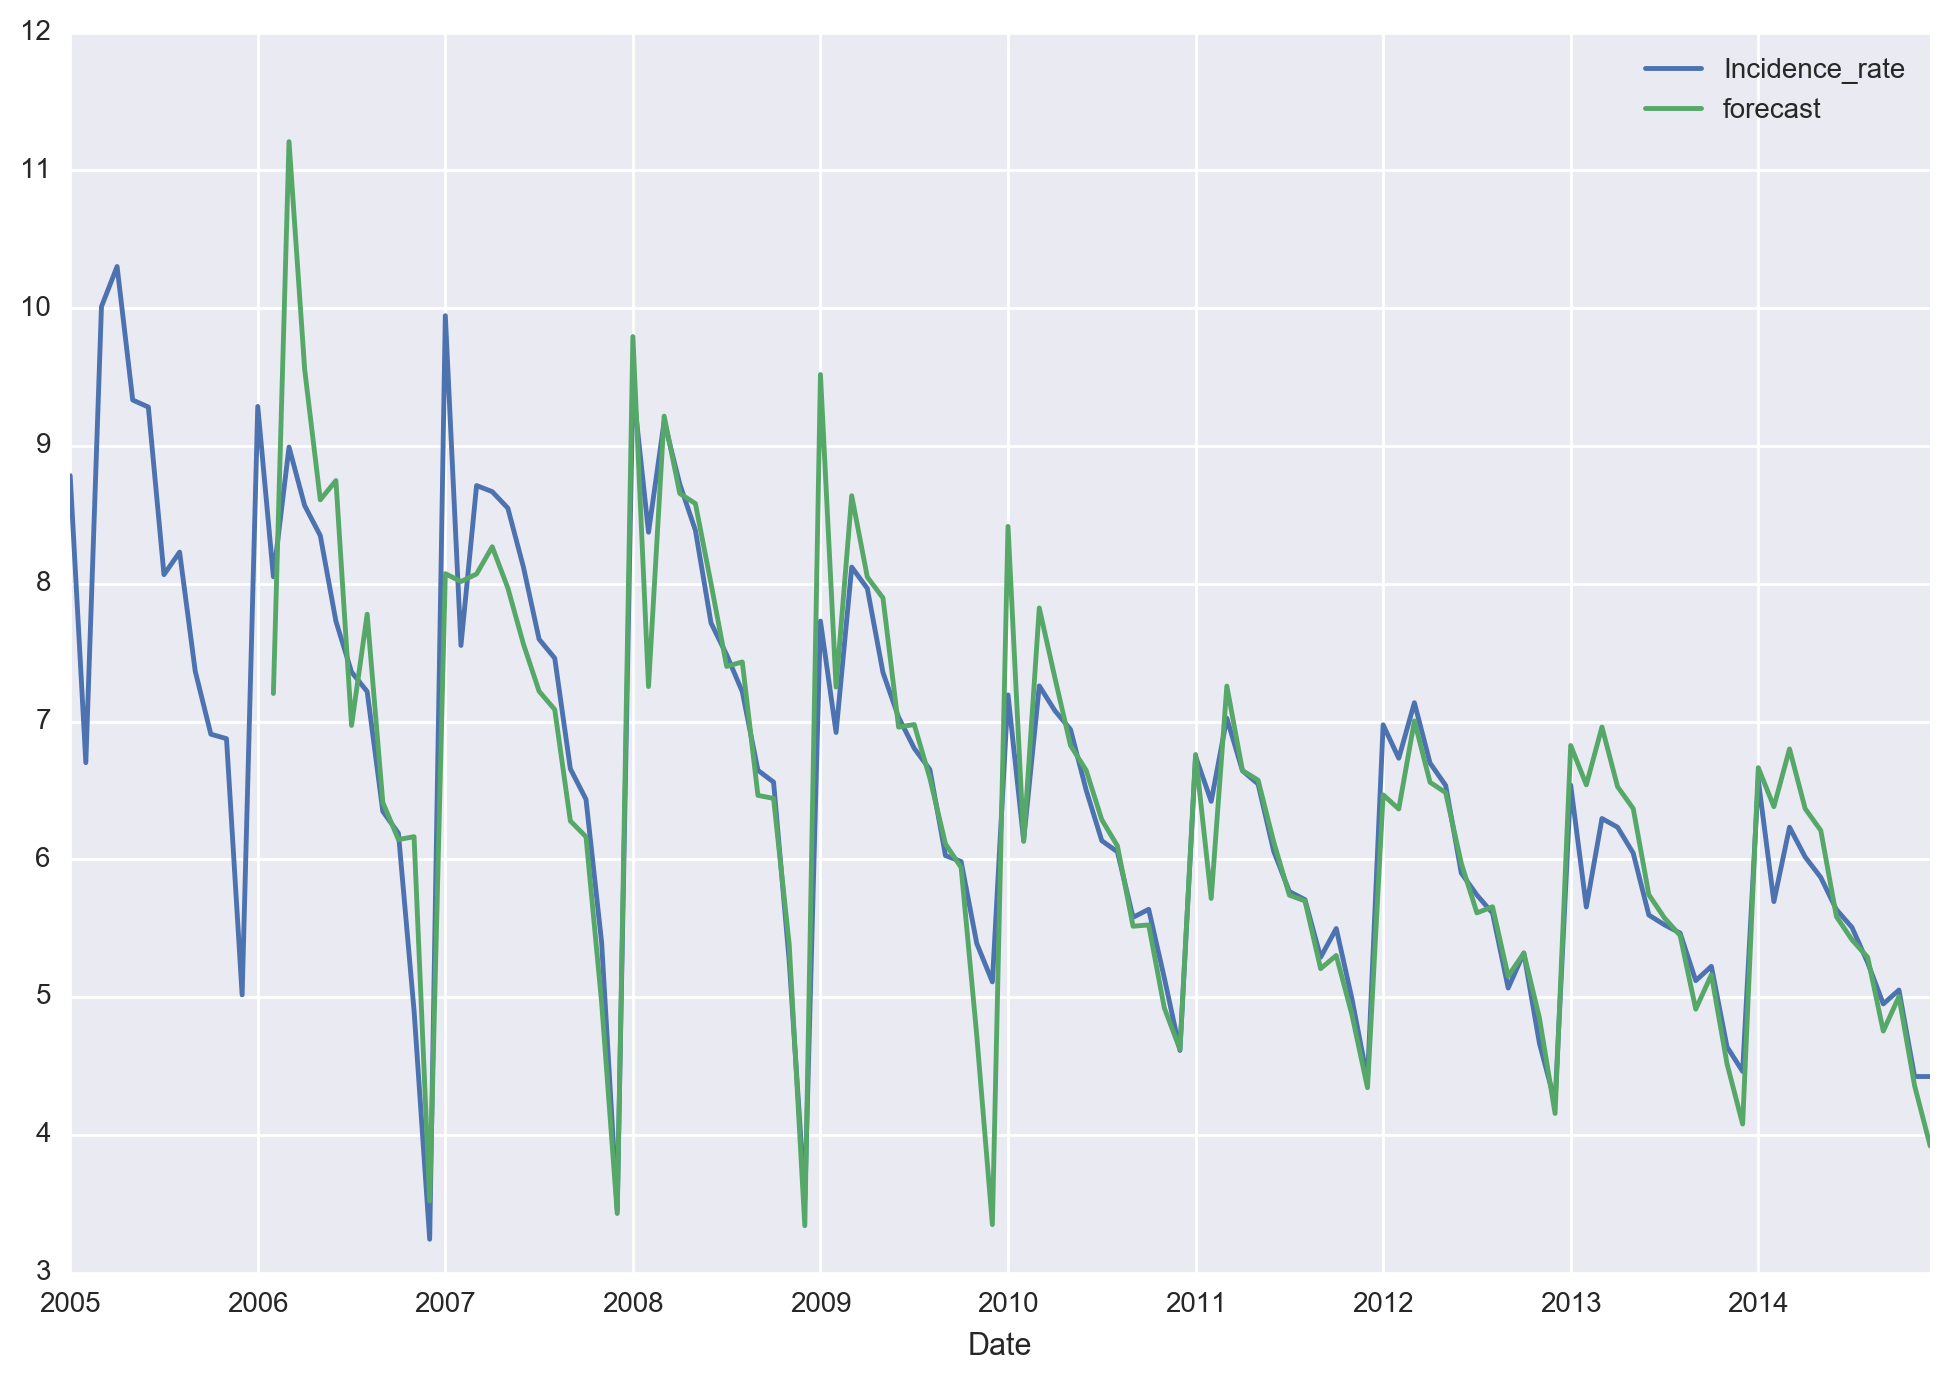

In [28]:
dta['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
dta[['Incidence_rate','forecast']].plot(figsize=(12, 8))

## SARIMA-GRNN Hybrid Model

## Load Packages

In [29]:
from sklearn import preprocessing as pp
from sklearn import cross_validation as cv
from neupy.algorithms import GRNN as grnn
from neupy.estimators import mse

/Users/evan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
data_train = dta.loc['2005-02-1':'2014-12-01'][['Incidence_rate','forecast','Month']]
data_train['Jan'] = data_train['Month']==1

x_train = data_train.loc[:'2012-12-01']['forecast']
y_train = data_train.loc[:'2012-12-01']['Incidence_rate']
x_test = data_train.loc['2013-01-01':]['forecast']
y_test = data_train['2013-01-01':]['Incidence_rate']

In [31]:
def try_std(x):
    nn = grnn(std =x ,verbose=False)
    nn.train(x_train,y_train)
    y_pred = nn.predict(x_test)
    print(mse(y_pred,y_test))

In [32]:
for x in np.linspace(0.3,0.6,10):
        print(x)
        try_std(x)
        print('--\n')

0.3
nan
--

0.333333333333
nan
--

0.366666666667
nan
--

0.4
nan
--

0.433333333333
nan
--

0.466666666667
nan
--

0.5
nan
--

0.533333333333
nan
--

0.566666666667
nan
--

0.6
nan
--



In [33]:
mod_GRNN = grnn(std = 0.4 ,verbose=False)
mod_GRNN.train(x_train,y_train)
data_train.loc[:,'NN']=mod_GRNN.predict(data_train['forecast'])

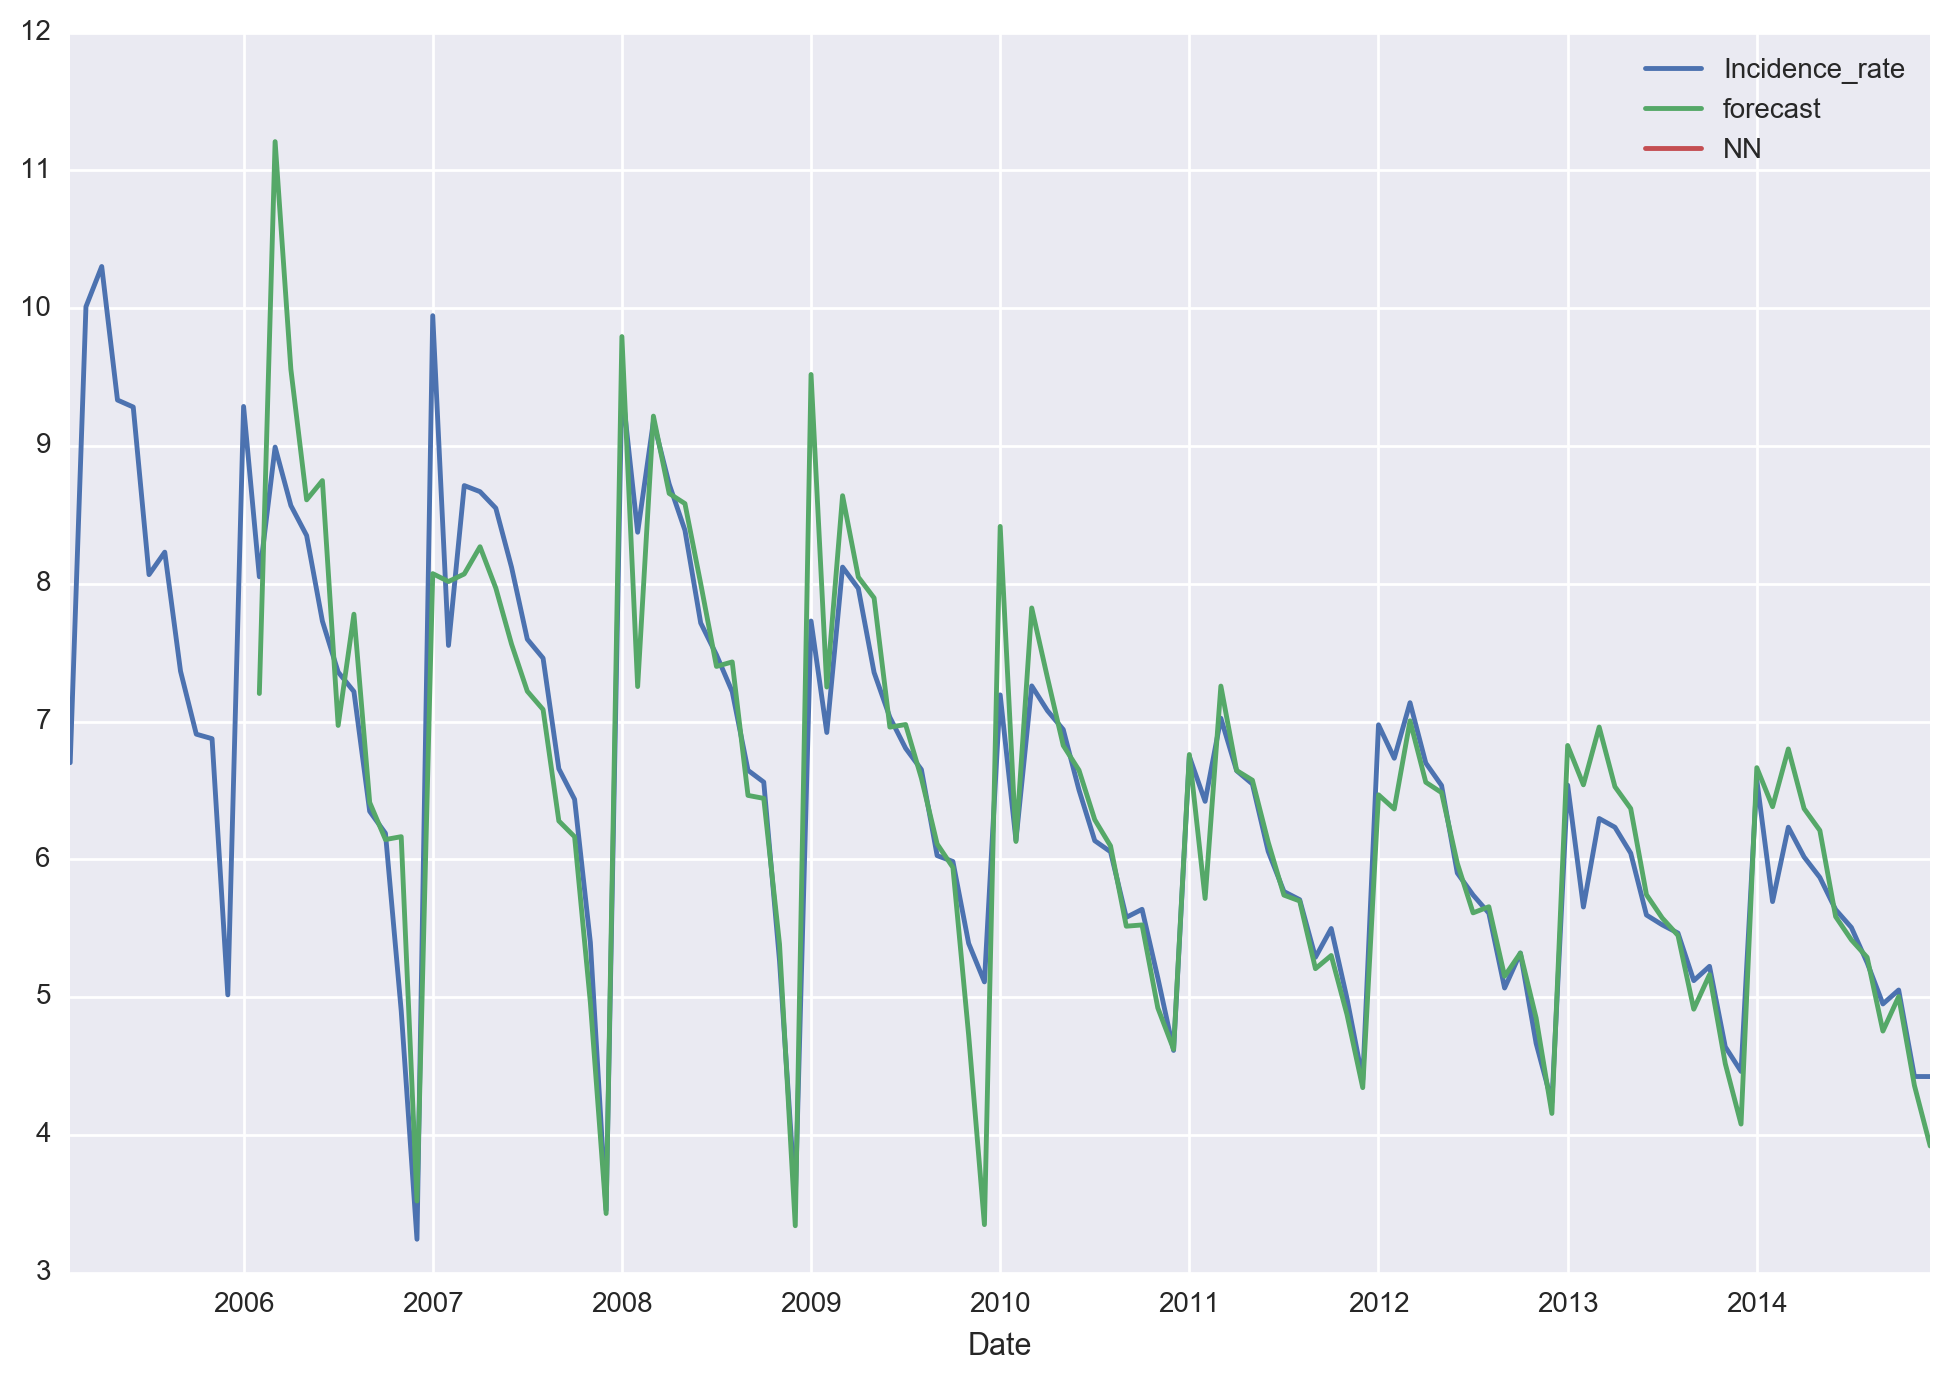

In [34]:
data_train[['Incidence_rate','forecast','NN']].plot(figsize=(12, 8)) 

In [35]:
data_train[['Incidence_rate','forecast','NN']]

## 绝对误差
data_train['Dist_ARIMA'] =abs(data_train['forecast']-data_train['Incidence_rate'])
data_train['Dist_GRNN'] = abs(data_train['NN']-data_train['Incidence_rate'])
data_train['Better'] = data_train['Dist_ARIMA']  - data_train['Dist_GRNN'] 

data_train['error_ARIMA'] = data_train['forecast']-data_train['Incidence_rate']
data_train['error_GRNN'] = data_train['NN']-data_train['Incidence_rate']

## 相对误差
data_train['ARIMA_per']  = (data_train['Dist_ARIMA']/data_train['Incidence_rate'])*100
data_train['GRNN_per'] = (data_train['Dist_GRNN']/data_train['Incidence_rate'])*100
np.mean(data_train['Dist_ARIMA'])
np.mean(data_train['Dist_GRNN'])
np.mean(data_train['ARIMA_per'])- np.mean(data_train['GRNN_per'])

nan

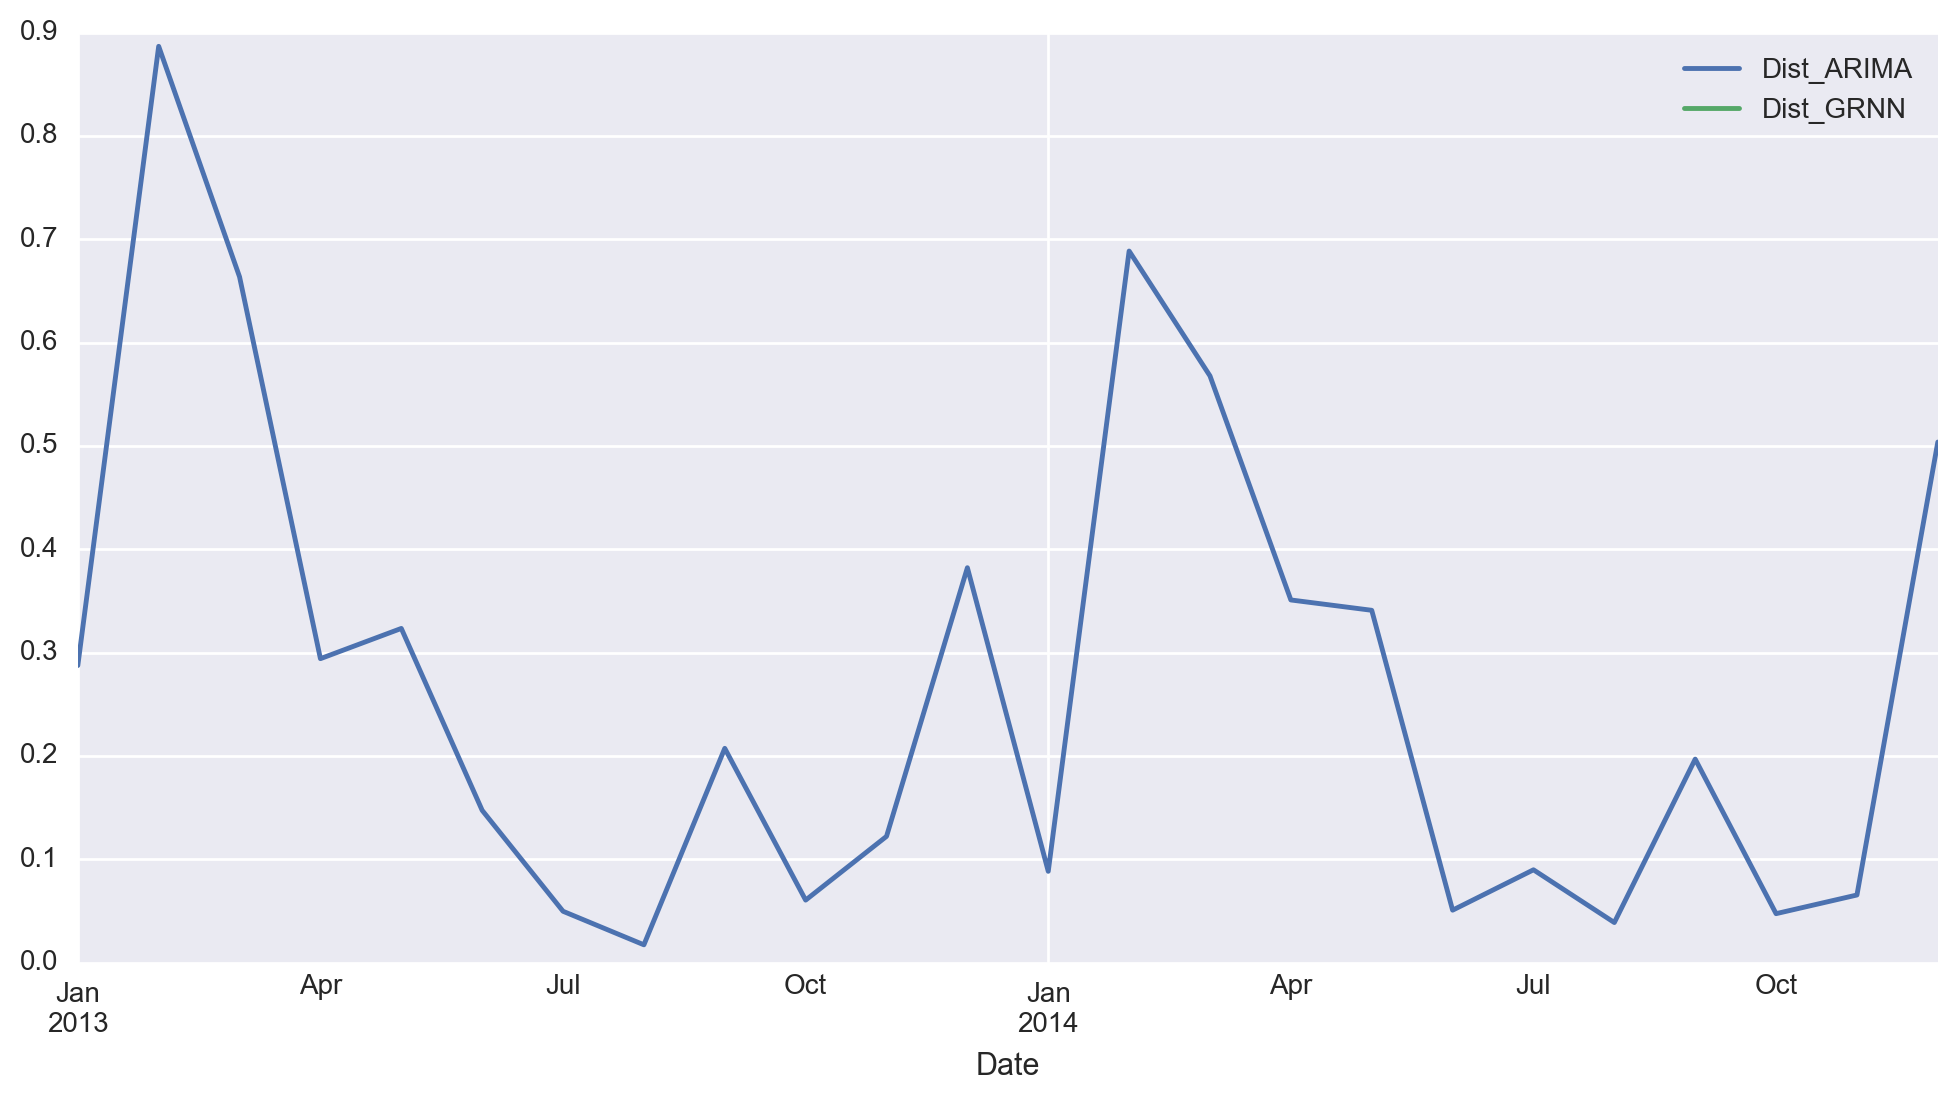

In [36]:
data_train[data_train.index>='2013-01-01'][['Dist_ARIMA','Dist_GRNN']].plot(figsize=(12,6))

In [37]:
data_out = data_train[data_train.index>='2013-01-01']

sum(data_out['ARIMA_per'])- sum(data_out['GRNN_per'])

np.mean(data_out['Dist_ARIMA'])-np.mean(data_out['Dist_GRNN'])

nan

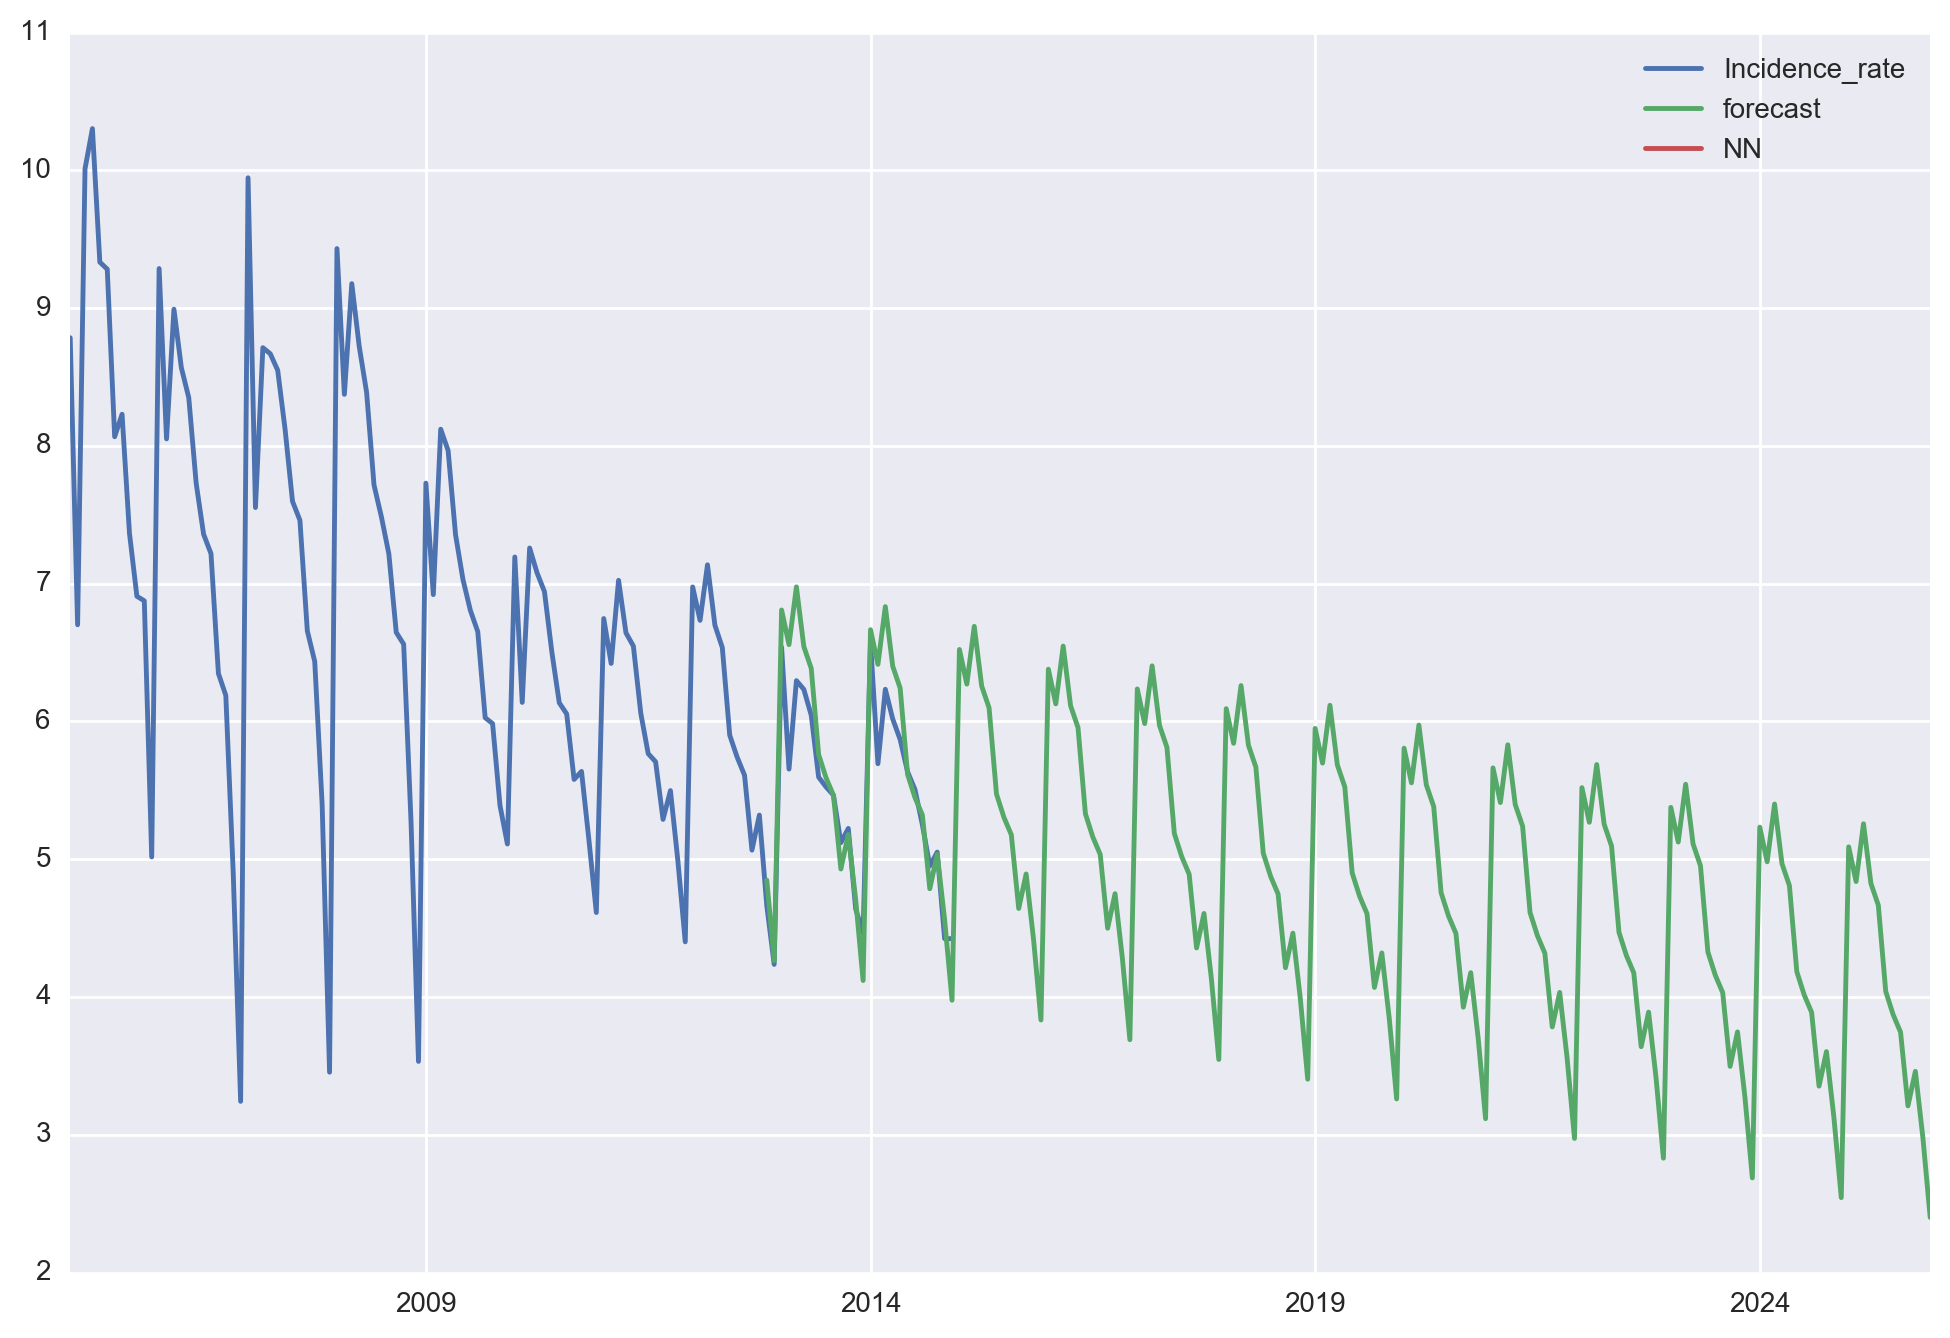

In [45]:
start = datetime.datetime.strptime("2015-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,132)]
future = pd.DataFrame(index=date_list, columns= dta.columns)
TB_future = pd.concat([dta, future])
TB_future['forecast'] = results.predict(start = 94, end = 251, dynamic= True)  
TB_future['NN'] = mod_GRNN.predict(TB_future['forecast'])
TB_future[['Incidence_rate', 'forecast','NN']].plot(figsize=(12, 8)) 

## Predict 2015-2025

In [ ]:
TB_2025 = TB_future[TB_future.index>='2025-01-01']['forecast']

In [ ]:
np.sum(TB_2025)